In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import os
import numpy as np
import scanpy as sc
import PyWGCNA
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import mannwhitneyu, false_discovery_control
import re
from itertools import combinations
from scipy.stats import pearsonr
import ast


KeyboardInterrupt



In [2]:
def stack_triangle(df, col):
    df = pd.DataFrame(
        df.where(
            np.tri(
                df.shape[0],
                dtype=bool,
                k=-1
            ),
            np.nan
        ).stack(dropna=True), columns=[col] 
    )
    
    return df


In [3]:
# Function that generates and saves the ROC curve
def generate_roc_curve(
    data,
    target_col,
    feature_col,
):
    # ROC curve using all gene pairs
    fpr, tpr, thr = roc_curve(data[target_col], data[feature_col])
    auroc = roc_auc_score(data[target_col], data[feature_col])
    
    return fpr, tpr, thr, auroc

In [4]:
def fig_to_panels(fig, axes, output_dir):
    # Save individual panels of a figure 
    
    for panel_name, ax in axes.items():
        # Extract the panel title
        panel_title = ax.get_title()

        # Sanitize the panel title to use in filenames
        safe_title = panel_title.replace(" ", "_").replace("/", "_").replace("\n", "_").lower()

        # Create the filename for the current panel
        output_file = os.path.join(output_dir,safe_title)

        # Adjust the bounding box to include everything (labels, titles, etc.)
        extent = ax.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())

        # Save the individual panel using the adjusted bounding box
        fig.savefig(output_file + '.pdf', bbox_inches=extent, dpi=300)
        fig.savefig(output_file + '.png', bbox_inches=extent)

        print(f"Saved panel '{panel_title}' to {output_file}")


In [6]:
def network_to_adj(network_path):
    network = pd.read_csv(
        network_path,
        usecols=['complex1', 'complex2', 'adj']
    )

    # Add a mirrored version of the network to make it symmetric
    network_mirrored = network.copy()
    network_mirrored.columns = ['complex2', 'complex1', 'adj']
    network = pd.concat([network, network_mirrored], ignore_index=True)

    adj = network.pivot(index='complex1', columns='complex2', values='adj').fillna(0)
    return adj

## 

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import false_discovery_control

In [2]:
# Define colors
# Light version is obtained by setting alpha=0.5

ncolor  = '#00728eff' # solid dark
ncolor2 = '#00728e80' # alpha=0.5
lightncolor = '#7fb8c6ff' # solid light

tcolor  = '#ab3502ff'
tcolor2 = '#ab350280'
lighttcolor = '#d49980ff'

graycolor = '#4D4E4FFF'
graycolor2 ='#4d4e4f80'

lightgray = '#C8CAD4'

orangecolor = '#e69426'
orangecolor2 = '#e6942680'
lightorangecolor = '#f2c992ff'

# Compare

In [3]:
df = pd.read_csv('/home/lnemati/pathway_crosstalk/results/compare_results.csv', index_col=0)
df = df.drop(columns=['avg_coev_tom_correlation'])

In [4]:
df = df[df.index != 'testis']

In [5]:
df['interactions_mannwhitneyu_p_adj'] = false_discovery_control(df['interactions_mannwhitneyu_p'], method='bh')

In [6]:
auroc_a = df['interactions_auroc']
auroc_t = df.query('condition == "tumor"')['interactions_auroc']
auroc_n = df.query('condition == "normal"')['interactions_auroc']

print('AUROC')

print('All tissues:', auroc_a.mean(), '+/-', np.std(auroc_a))
print('Normal', auroc_n.mean(), '+/-', np.std(auroc_n))
print('Tumor', auroc_t.mean(), '+/-', np.std(auroc_t))

ua = df['interactions_mannwhitneyu_U']
ut = df.query('condition == "tumor"')['interactions_mannwhitneyu_U']
un = df.query('condition == "normal"')['interactions_mannwhitneyu_U']

AUROC
All tissues: 0.6165693346411175 +/- 0.03869659366368164
Normal 0.5913339627313167 +/- 0.020279851115496902
Tumor 0.6528451817614561 +/- 0.028764581664141135


In [7]:
df['-log10_mannwhitneyu_p_adj'] = -np.log10(df['interactions_mannwhitneyu_p_adj'])

In [8]:
df.drop(columns='interactions_mannwhitneyu_p', inplace=True)
df.drop(columns='interactions_mannwhitneyu_p_adj', inplace=True)

/var/tmp/pbs.366636.pbs01/ipykernel_29691/972413527.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='condition', y=column, data=df, palette=[ncolor, tcolor])
/var/tmp/pbs.366636.pbs01/ipykernel_29691/972413527.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='condition', y=column, data=df, palette=[ncolor, tcolor])
/var/tmp/pbs.366636.pbs01/ipykernel_29691/972413527.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='condition', y=column, data=df, palette=[ncolor, tcolor])
/var/tmp/pbs.366636.pbs01/ipykernel_2

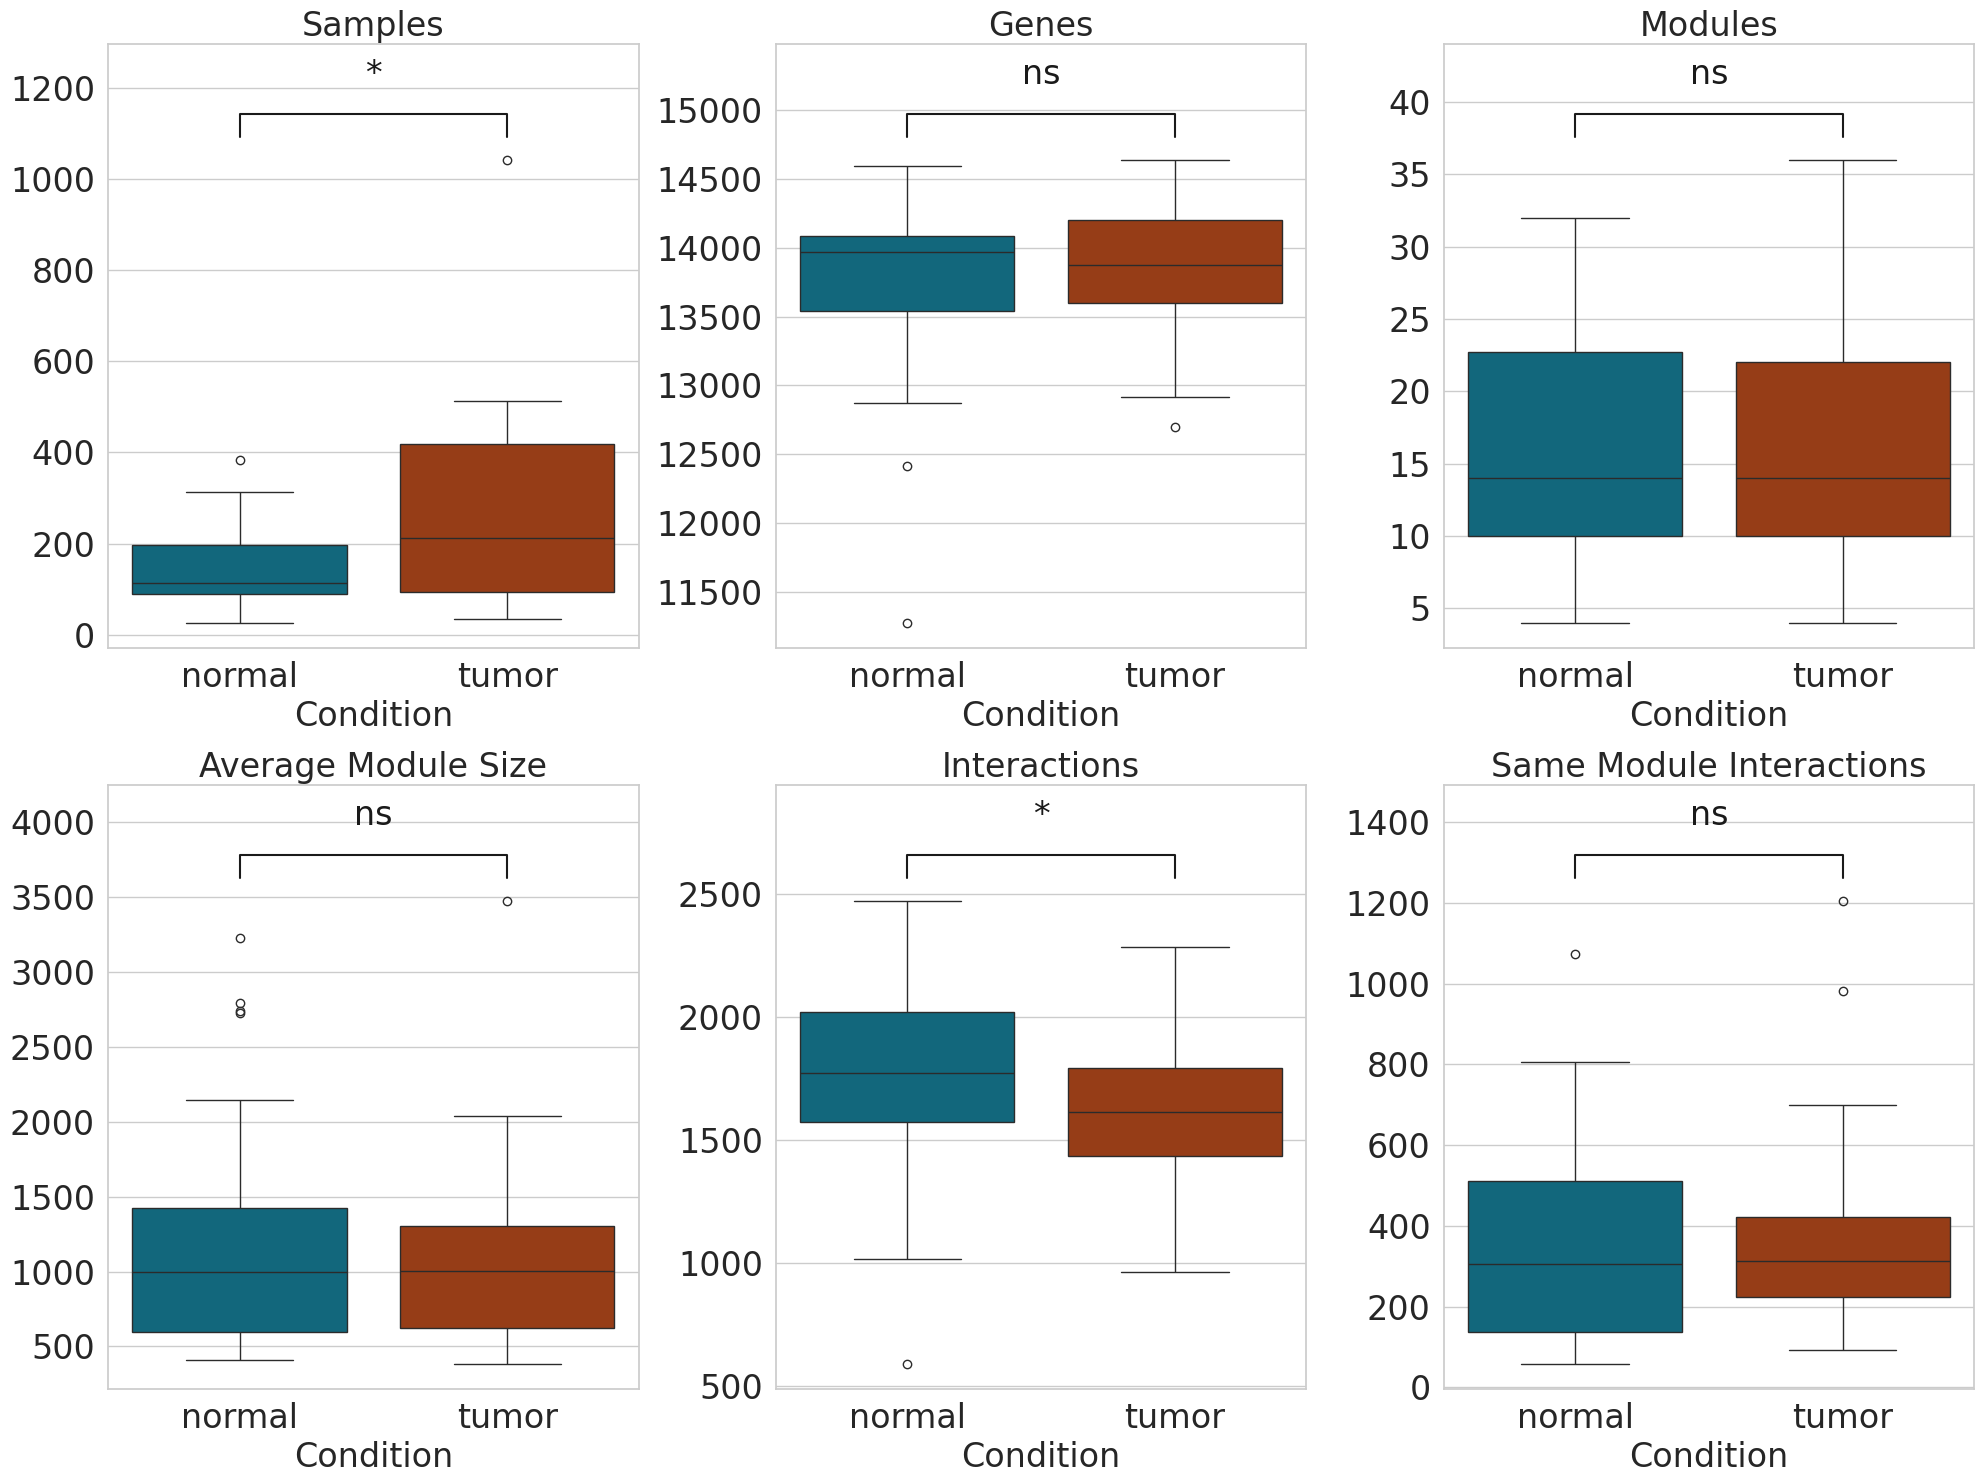

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Title dictionary for subplots
title_dict = {
    'n_samples': 'Samples',
    'n_genes': 'Genes',
    'n_modules': 'Modules',
    'avg_module_size': 'Average Module Size',
    #'avg_degree': 'Average Degree',
    #'avg_intramodular_degree': 'Average Intramodular Degree',
    'tot_interactions': 'Interactions',
    'n_interactions_same_module': 'Same Module Interactions',
    #'interactions_auroc': 'AUROC',
    #'interactions_mannwhitneyu_U': 'Mann-Whitney $U$',
    #'-log10_mannwhitneyu_p_adj': 'Mann-Whitney $-log_{10}{p_{adj}}$',
}

# Set the style
sns.set(style="whitegrid")

# Define font size
fs = 24

# Function to perform Mann-Whitney U test and return p-value
def compute_p_value(data, column):
    """Compute p-value for Mann-Whitney U test."""
    normal_data = data[data['condition'] == 'normal'][column]
    tumor_data = data[data['condition'] == 'tumor'][column]
    _, p_value = mannwhitneyu(normal_data, tumor_data, alternative='two-sided')
    return p_value

# Function to add significance bars to the boxplot
def add_significance(ax, data, column, p_value):
    """ Adds significance bars to the given axes object based on p-value. """
    # Determine the significance level
    if p_value < 0.001:
        significance = '***'
    elif p_value < 0.01:
        significance = '**'
    elif p_value < 0.05:
        significance = '*'
    else:
        significance = 'ns'  # Not significant

    # Calculate maximum y-value and add space for significance bar
    normal_data = data[data['condition'] == 'normal'][column]
    tumor_data = data[data['condition'] == 'tumor'][column]
    y_max = max(normal_data.max(), tumor_data.max())
    y_min = min(normal_data.min(), tumor_data.min())
    y_offset = 0.2 * (y_max - y_min if y_max > y_min else 1)

    h = 0.05 * (y_max - y_min)  # Height of the significance bar
    y_bar_start = y_max + h
    y_bar_end = y_max + 2 * h

    x1, x2 = 0, 1
    col = 'k'

    # Plot the significance bar
    ax.plot([x1, x1, x2, x2], [y_bar_start, y_bar_end, y_bar_end, y_bar_start], lw=1.5, c=col)
    ax.text((x1 + x2) * 0.5, y_bar_end + h, significance, ha='center', va='bottom', color=col, fontsize=fs)

    # Update the y-axis limit to make space for the significance bar
    ax.set_ylim(top=y_bar_end + h * 3)  # Adding extra space to avoid overlap with titles

# Define columns to plot based on the title_dict
columns = list(title_dict.keys())

# Collect p-values for FDR correction
p_values = [compute_p_value(df, column) for column in columns]

# Apply FDR correction
#p_values = stats.false_discovery_control(p_values, method='bh')

# Create a dictionary of corrected p-values
p_value_dict = dict(zip(columns, p_values))

# Plot boxplots for each column
plt.figure(figsize=(20, 15))  # Adjusted figure size for better spacing

subplot_shape = (2,3)

# Plot the countplot for 'condition'
#plt.subplot(subplot_shape[0], subplot_shape[1], 1)
#sns.countplot(x='condition', data=df, palette=[ncolor, tcolor])
#plt.title('Tissues', fontsize=fs)
#plt.xlabel('Condition', fontsize=fs)
#plt.ylabel('', fontsize=fs)
#plt.xticks(fontsize=fs)
#plt.yticks(fontsize=fs)

# Plot boxplots for each column in the title_dict
for i, column in enumerate(columns):
    plt.subplot(subplot_shape[0], subplot_shape[1], i + 1)
    ax = sns.boxplot(x='condition', y=column, data=df, palette=[ncolor, tcolor])
    plt.title(title_dict[column], fontsize=fs)
    plt.xlabel('Condition', fontsize=fs)
    plt.ylabel('', fontsize=fs)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)

    # Add significance bars
    add_significance(ax, df, column, p_value_dict[column])

plt.tight_layout()

# Save the figure
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/comparison_all.pdf')

# Show the plot
plt.show()


In [10]:
df['prob_same_module'] = df.n_interactions_same_module / df.tot_interactions

/var/tmp/pbs.366636.pbs01/ipykernel_29691/4241850758.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/tmp/pbs.366636.pbs01/ipykernel_29691/4241850758.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


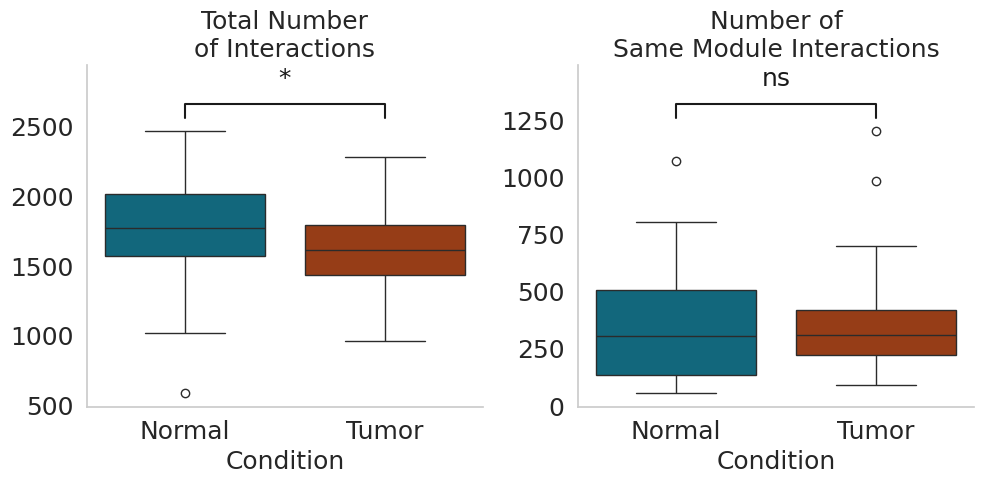

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Title dictionary for subplots
title_dict = {
    'tot_interactions': 'Total Number\nof Interactions',
    'n_interactions_same_module': 'Number of\nSame Module Interactions',
    #'prob_same_module': 'Fraction of\nSame Module Interactions'
}

# Set the style
sns.set(style="whitegrid")

# Define font size
fs = 18

# Function to perform Mann-Whitney U test and return p-value
def compute_p_value(data, column):
    """Compute p-value for Mann-Whitney U test."""
    normal_data = data[data['condition'] == 'normal'][column]
    tumor_data = data[data['condition'] == 'tumor'][column]
    _, p_value = mannwhitneyu(normal_data, tumor_data, alternative='two-sided')
    return p_value

# Function to add significance bars to the boxplot
def add_significance(ax, data, column, p_value):
    """ Adds significance bars to the given axes object based on p-value. """
    # Determine the significance level
    if p_value < 0.001:
        significance = '***'
    elif p_value < 0.01:
        significance = '**'
    elif p_value < 0.05:
        significance = '*'
    else:
        significance = 'ns'  # Not significant

    # Calculate maximum y-value and add space for significance bar
    normal_data = data[data['condition'] == 'normal'][column]
    tumor_data = data[data['condition'] == 'tumor'][column]
    y_max = max(normal_data.max(), tumor_data.max())
    y_min = min(normal_data.min(), tumor_data.min())
    y_offset = 0.2 * (y_max - y_min if y_max > y_min else 1)

    h = 0.05 * (y_max - y_min)  # Height of the significance bar
    y_bar_start = y_max + h
    y_bar_end = y_max + 2 * h

    x1, x2 = 0, 1
    col = 'k'

    # Plot the significance bar
    ax.plot([x1, x1, x2, x2], [y_bar_start, y_bar_end, y_bar_end, y_bar_start], lw=1.5, c=col)
    ax.text((x1 + x2) * 0.5, y_bar_end + h, significance, ha='center', va='bottom', color=col, fontsize=fs)

    # Update the y-axis limit to make space for the significance bar
    ax.set_ylim(top=y_bar_end + h * 3)  # Adding extra space to avoid overlap with titles

# Define columns to plot based on the title_dict
columns = list(title_dict.keys())

# Collect p-values for FDR correction
p_values = [compute_p_value(df, column) for column in columns]

# Apply FDR correction
#p_values = false_discovery_control(p_values, method='bh')

# Create a dictionary of corrected p-values
p_value_dict = dict(zip(columns, p_values))

# Plot boxplots for each column

subplot_shape = (1,len(title_dict))

fig, axes = plt.subplots(subplot_shape[0], subplot_shape[1], figsize=(5 * subplot_shape[1], 5))

# Plot boxplots for each column in the title_dict
for i, column in enumerate(columns):
    sns.boxplot(
        x='condition',
        y=column,
        data=df.replace({'normal': 'Normal', 'tumor': 'Tumor'}),
        palette=[ncolor, tcolor],
        ax=axes[i]
    )
    axes[i].set_title(title_dict[column], fontsize=fs)
    axes[i].set_xlabel('Condition', fontsize=fs)
    axes[i].set_ylabel('', fontsize=fs)
    axes[i].tick_params(labelsize=fs)
    axes[i].grid(False)
    axes[i].spines[['right', 'top']].set_visible(False)

    #axes[i].xticks(fontsize=fs)
    #axes[i].yticks(fontsize=fs)

    # Add significance bars
    add_significance(axes[i], df, column, p_value_dict[column])

plt.tight_layout()

# Save the figure
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/comparison_interactions.pdf')
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/comparison_interactions.png')

# Show the plot
plt.show()


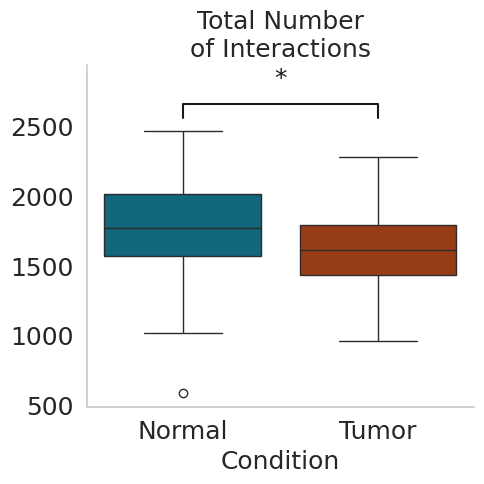

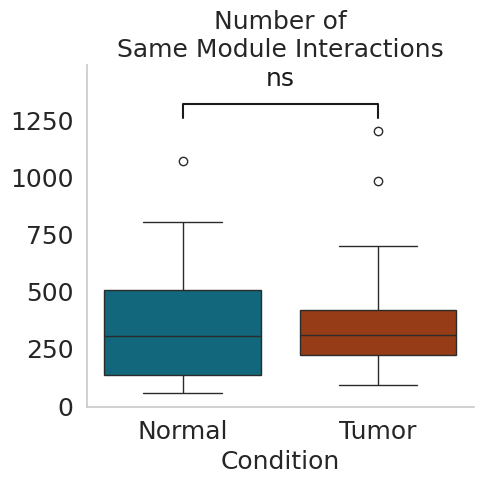

In [12]:
# First figure: Total Number of Interactions
fig1, ax1 = plt.subplots(figsize=(5, 5))
sns.boxplot(
    x='condition',
    y='tot_interactions',
    hue='condition',
    data=df.replace({'normal': 'Normal', 'tumor': 'Tumor'}),
    palette=[ncolor, tcolor],
    ax=ax1
)
ax1.set_title(title_dict['tot_interactions'], fontsize=fs)
ax1.set_xlabel('Condition', fontsize=fs)
ax1.set_ylabel('', fontsize=fs)
ax1.tick_params(labelsize=fs)
ax1.grid(False)
ax1.spines[['right', 'top']].set_visible(False)

# Add significance bars for the first plot
add_significance(ax1, df, 'tot_interactions', p_value_dict['tot_interactions'])

# Save the first figure
plt.tight_layout()
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/interactions_total.pdf')
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/interactions_total.png')

# Show the first plot
plt.show()

# Second figure: Number of Same Module CCIs
fig2, ax2 = plt.subplots(figsize=(5, 5))
sns.boxplot(
    x='condition',
    y='n_interactions_same_module',
    hue='condition',
    data=df.replace({'normal': 'Normal', 'tumor': 'Tumor'}),
    palette=[ncolor, tcolor],
    ax=ax2
)
ax2.set_title(title_dict['n_interactions_same_module'], fontsize=fs)
ax2.set_xlabel('Condition', fontsize=fs)
ax2.set_ylabel('', fontsize=fs)
ax2.tick_params(labelsize=fs)
ax2.grid(False)
ax2.spines[['right', 'top']].set_visible(False)

# Add significance bars for the second plot
add_significance(ax2, df, 'n_interactions_same_module', p_value_dict['n_interactions_same_module'])

# Save the second figure
plt.tight_layout()
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/interactions_same_module.pdf')
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/interactions_same_module.png')

# Show the second plot
plt.show()


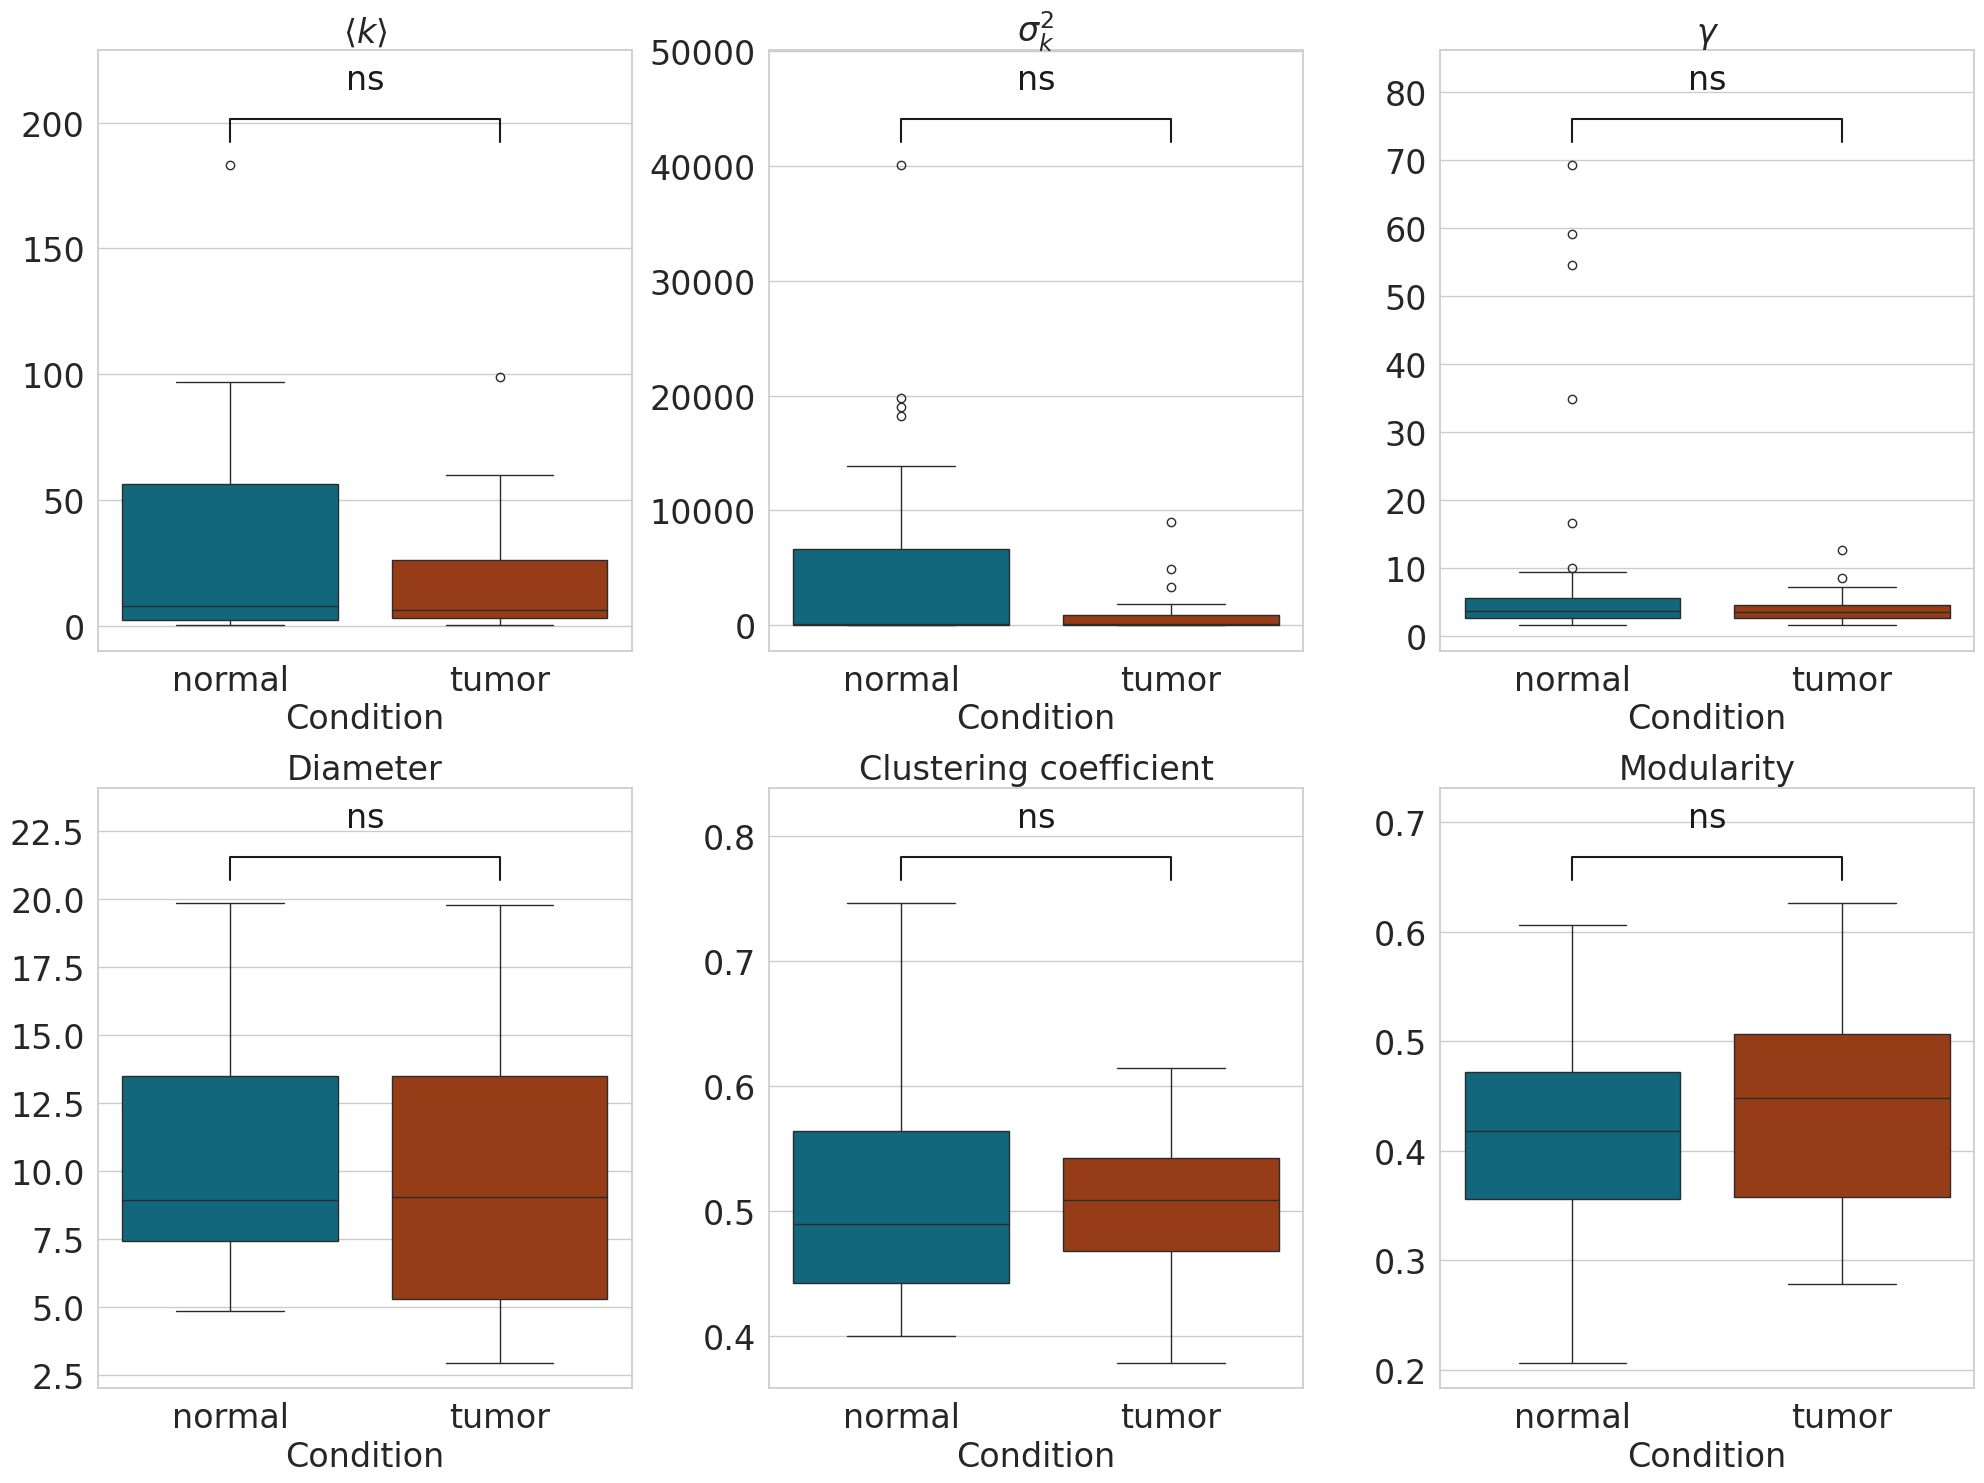

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Title dictionary for subplots
# Title dictionary for subplots
title_dict = {
    'avg_degree': '$ \langle k \\rangle $',
    #'avg_intramodular_degree': 'avg_intramodular_degree',
    'var_degree': '$ \sigma^2_{k}$',
    #'var_intramodular_degree': 'variance_intramodular',
    'powerlaw_alpha': '$\gamma$',
    #'avg_shortest_path': 'avg_path_length',
    'diameter': 'Diameter',
    'clustering_global': 'Clustering coefficient',
    'modularity': 'Modularity',
    #'powerlaw_xmin': 'xmin',
    #'powerlaw_sigma': 'sigma'
}

# Set the style
sns.set(style="whitegrid")

# Define font size
fs = 24

# Function to perform Mann-Whitney U test and return p-value
def compute_p_value(data, column):
    """Compute p-value for Mann-Whitney U test."""
    normal_data = data[data['condition'] == 'normal'][column]
    tumor_data = data[data['condition'] == 'tumor'][column]
    _, p_value = mannwhitneyu(normal_data, tumor_data, alternative='two-sided')
    return p_value

# Function to add significance bars to the boxplot
def add_significance(ax, data, column, p_value):
    """ Adds significance bars to the given axes object based on p-value. """
    # Determine the significance level
    if p_value < 0.001:
        significance = '***'
    elif p_value < 0.01:
        significance = '**'
    elif p_value < 0.05:
        significance = '*'
    else:
        significance = 'ns'  # Not significant

    # Calculate maximum y-value and add space for significance bar
    normal_data = data[data['condition'] == 'normal'][column]
    tumor_data = data[data['condition'] == 'tumor'][column]
    y_max = max(normal_data.max(), tumor_data.max())
    y_min = min(normal_data.min(), tumor_data.min())
    y_offset = 0.2 * (y_max - y_min if y_max > y_min else 1)

    h = 0.05 * (y_max - y_min)  # Height of the significance bar
    y_bar_start = y_max + h
    y_bar_end = y_max + 2 * h

    x1, x2 = 0, 1
    col = 'k'

    # Plot the significance bar
    ax.plot([x1, x1, x2, x2], [y_bar_start, y_bar_end, y_bar_end, y_bar_start], lw=1.5, c=col)
    ax.text((x1 + x2) * 0.5, y_bar_end + h, significance, ha='center', va='bottom', color=col, fontsize=fs)

    # Update the y-axis limit to make space for the significance bar
    ax.set_ylim(top=y_bar_end + h * 3)  # Adding extra space to avoid overlap with titles

# Define columns to plot based on the title_dict
columns = list(title_dict.keys())

# Collect p-values for FDR correction
p_values = [compute_p_value(df, column) for column in columns]

# Apply FDR correction
#p_values = stats.false_discovery_control(p_values, method='bh')

# Create a dictionary of corrected p-values
p_value_dict = dict(zip(columns, p_values))

# Plot boxplots for each column
plt.figure(figsize=(20, 15))  # Adjusted figure size for better spacing

subplot_shape = (2,3)

# Plot boxplots for each column in the title_dict
for i, column in enumerate(columns):
    plt.subplot(subplot_shape[0], subplot_shape[1], i + 1)
    ax = sns.boxplot(
        x='condition',
        y=column,
        hue='condition',
        data=df,
        palette=[ncolor, tcolor]
    )
    plt.title(title_dict[column], fontsize=fs)
    plt.xlabel('Condition', fontsize=fs)
    plt.ylabel('', fontsize=fs)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)

    # Add significance bars
    add_significance(ax, df, column, p_value_dict[column])

plt.tight_layout()

# Save the figure
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/comparison_networks.pdf')

# Show the plot
plt.show()

In [14]:
#import pandas as pd
#import seaborn as sns
#import matplotlib.pyplot as plt
#
## Set the style
#sns.set_style("whitegrid", {'axes.grid': False})
#
## Define font size
#fs = 24
#
## Plot boxplots for each column
#plt.figure(figsize=(6, 12))  # Adjust the figure size to accommodate smaller vertical subplots
#
#title_dict = {
#    'interactions_auroc': 'AUROC',
#    #'interactions_mannwhitneyu_U': 'Rank-Sum $U$',
#    '-log10_mannwhitneyu_p_adj': 'Rank-Sum $-log_{10}{p_{adj}}$',
#}
#
#for i, column in enumerate(title_dict.keys()):
#    plt.subplot(len(title_dict), 1, i + 1)  # Change the subplot to vertical arrangement
#    sns.boxplot(x='condition', y=column, data=df.replace({'normal': 'Normal', 'tumor': 'Tumor'}), palette=[ncolor, tcolor])
#    plt.title(title_dict[column], fontsize=fs)
#    plt.xlabel('Condition', fontsize=fs)
#    plt.ylabel('', fontsize=fs)
#    plt.xticks(fontsize=fs)
#    plt.yticks(fontsize=fs)
#
#plt.tight_layout()
#
## Save the figure
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/comparison_mannwhitneyu_auroc.pdf')
#
## Show the plot
#plt.show()
#

In [15]:
# COEVOLUTION

from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import mannwhitneyu
from itertools import combinations, product

# Function that generates and saves the ROC curve
def generate_roc_curve(
    data,
    target_col,
    feature_col,
    name=None,
):
    # ROC curve using all gene pairs
    fpr, tpr, _ = roc_curve(data[target_col], data[feature_col])
    auroc = roc_auc_score(data[target_col], data[feature_col])
    
    return fpr, tpr, auroc

def update_diff_complex(
    all_pairs,
    genes_series_a,
    genes_series_b
):
    for genes_a, genes_b in zip(genes_series_a, genes_series_b):
        for pair in product(genes_a, genes_b):
            gene_a, gene_b = pair
            if pair in all_pairs.index:
                all_pairs.loc[pair, "interaction"] = 1
            elif (gene_b, gene_a) in all_pairs.index:
                all_pairs.loc[(gene_b, gene_a), "interaction"] = 1
    return

print("Reading interactions.csv")
# read interactions.csv 
interactions = pd.read_csv('/projects/bioinformatics/DB/CellCellCommunication/WithEnzymes/cpdb_cellchat_enz.csv')
coev = pd.read_csv('/home/lnemati/resources/coevolution/jaccard_genes.csv.gz', index_col=0)

# Extract genes for complex A and B for each row
complex_a_genes = interactions.apply(lambda row: list(set([row[f'interactor{i}'] for i in range(1, row['num_interactors_a'] + 1) if pd.notna(row[f'interactor{i}'])])), axis=1)
complex_b_genes = interactions.apply(lambda row: list(set([row[f'interactor{i}'] for i in range(row['num_interactors_a'] + 1, row['num_interactors_a'] + row['num_interactors_b'] + 1) if pd.notna(row[f'interactor{i}'])])), axis=1)
interactions_all_genes = complex_a_genes + complex_b_genes

# make all_interacting_genes a list containing all unique genes in the interactions
all_interacting_genes = list(set().union(*interactions_all_genes))
print("Number of interacting genes: ", len(all_interacting_genes))

# ----- ROC all gene pairs -----

print("Generating ROC curves")

print("coev has shape: ", coev.shape)

# flatten TOM matrix, remove diagonal and duplicated values
print("Flattening coev matrix")
all_pairs = pd.DataFrame(
    coev.where(
        np.tri(
            coev.shape[0],
            dtype=bool,
            k=-1
        ),
        np.nan
    ).stack(dropna=True), columns=["coev"]
)
print("all_pairs has now shape: ", all_pairs.shape)

all_pairs['interaction'] = 0

update_diff_complex(all_pairs, complex_a_genes, complex_b_genes)

print("Total number of interacting pairs: ", all_pairs["interaction"].sum())

# Diff complex interactions
coev_fpr, coev_tpr, coev_auroc = generate_roc_curve(
    data=all_pairs,
    target_col="interaction",
    feature_col="coev",
    name='Coevoulution'
)

Reading interactions.csv
Number of interacting genes:  1576
Generating ROC curves
coev has shape:  (17756, 17756)
Flattening coev matrix


/var/tmp/pbs.366636.pbs01/ipykernel_29691/2763671280.py:57: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  coev.where(


all_pairs has now shape:  (157628890, 1)
Total number of interacting pairs:  3467


In [18]:
all_pairs = all_pairs.reset_index()
all_pairs

,level_0,level_1,coev,interaction
0,A2M,A1BG,0.439024,0
1,A2ML1,A1BG,0.428571,0
2,A2ML1,A2M,0.524823,0
3,A3GALT2,A1BG,0.392523,0
4,A3GALT2,A2M,0.345912,0
...,...,...,...,...
157628885,ZZZ3,ZXDC,0.404110,0
157628886,ZZZ3,ZYG11A,0.333333,0
157628887,ZZZ3,ZYG11B,0.622642,0
157628888,ZZZ3,ZYX,0.536697,0


In [ ]:
all_pairs.to_csv('/home/lnemati/pathway_crosstalk/results/comparison/all_pairs_coev.csv.gz')

ERROR! Session/line number was not unique in database. History logging moved to new session 4445


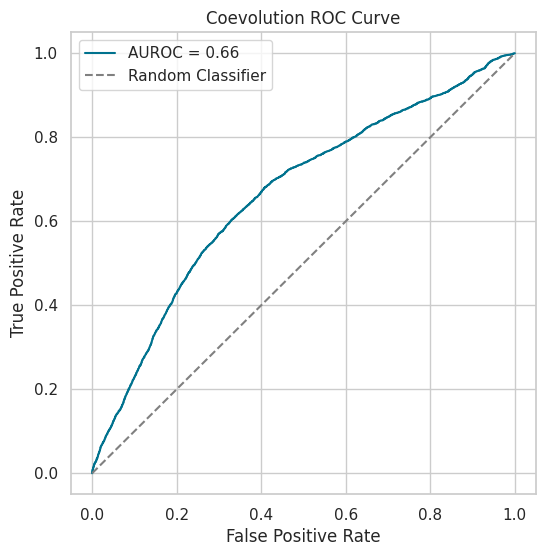

In [19]:
plt.figure(figsize=(6, 6))
plt.plot(coev_fpr, coev_tpr, label=f'AUROC = {coev_auroc:.2f}', color=ncolor)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Coevolution ROC Curve')
plt.legend(loc='upper left')
#plt.grid(True)
plt.show()


In [20]:
import numpy as np
from scipy.interpolate import interp1d

def interpolate_data(x_data, y_data, new_x):
    """
    Interpolate y_data to match new_x using linear interpolation.

    Parameters:
    x_data : array-like
        The original x data points.
    y_data : array-like
        The original y data points corresponding to x_data.
    new_x : array-like
        The new x data points for which we want to compute interpolated y values.

    Returns:
    new_x : array-like
        The input new_x values (unchanged).
    new_y : array-like
        The interpolated y values corresponding to new_x.
    """
    # Create an interpolation function
    interpolation_func = interp1d(x_data, y_data, kind='linear', fill_value="extrapolate")
    
    # Compute new_y by applying the interpolation function to new_x
    new_y = interpolation_func(new_x)
    
    return new_x, new_y


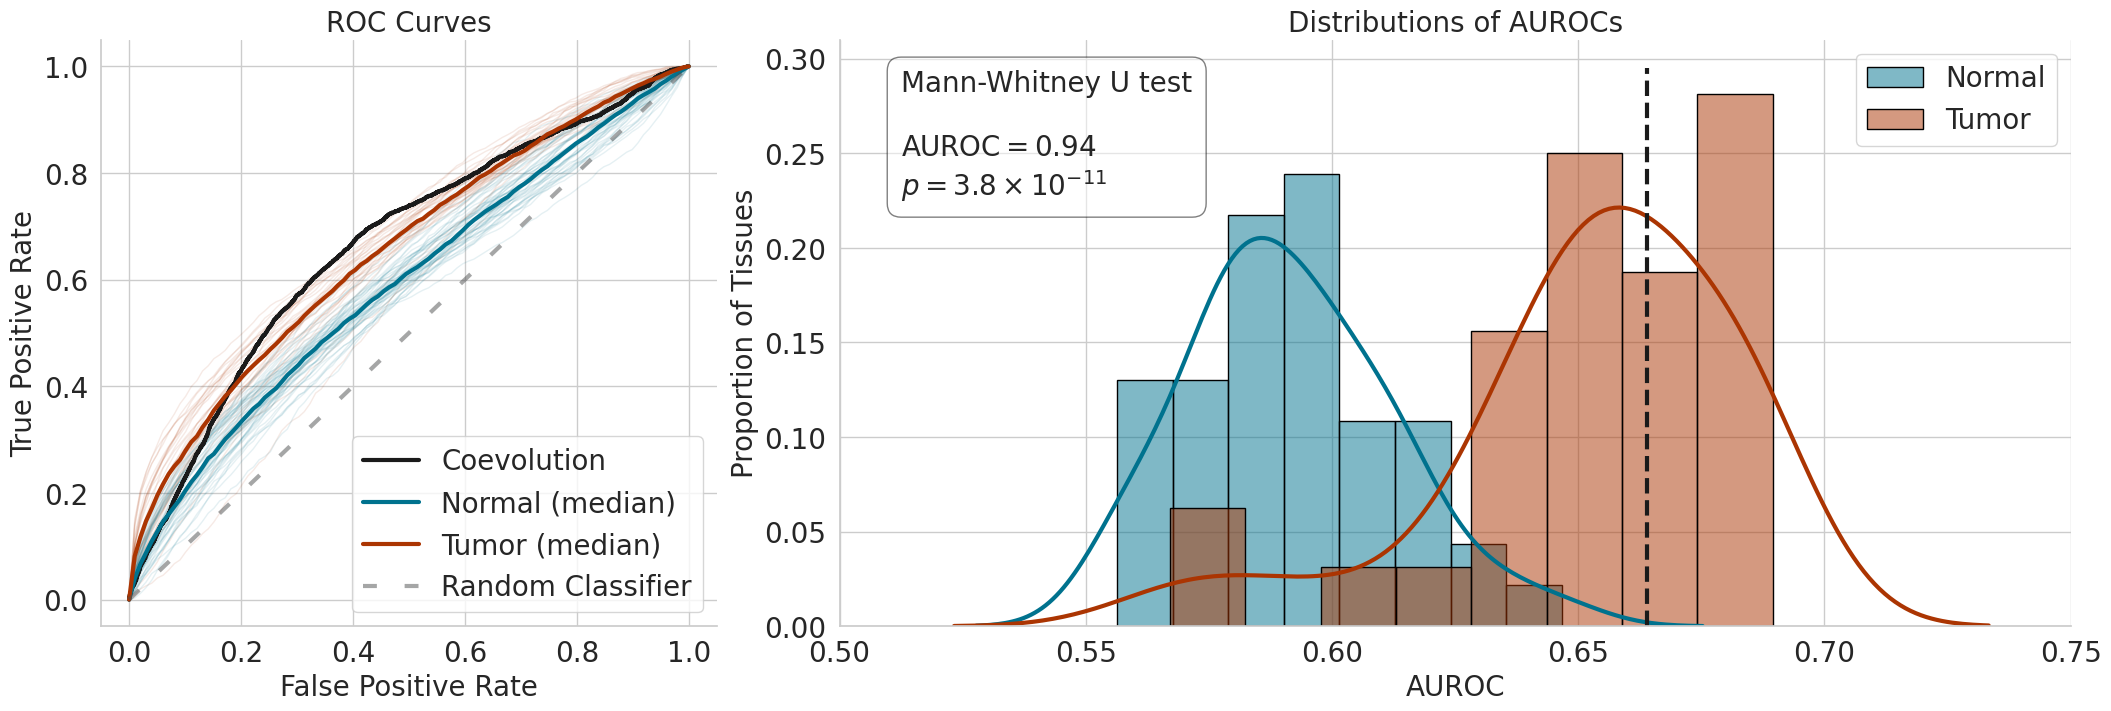

In [21]:
# Define font size
fs = 20

# Data Preparation for AUROC
col = 'interactions_auroc'
normal_data = df.loc[df.condition == 'normal', col]
tumor_data = df.loc[df.condition == 'tumor', col]

# Perform Mann-Whitney U test
u_statistic, mannwhitney_p_value = mannwhitneyu(tumor_data, normal_data, alternative='greater')

# Create the figure
fig = plt.figure(layout="constrained", figsize=(21, 7))

axs = fig.subplot_mosaic(
    """
    ABB
    """
)

lw = 3
cut = 3
alpha=0.5
bins=8


# ----- PLOT A (ROC) ------

xx = np.linspace(0,1,100)

path = '/home/lnemati/pathway_crosstalk/results/roc/tumor'
t_yy = []

for tissue in os.listdir(path):
    fpr = np.load(os.path.join(path, tissue, 'fpr.npy'))
    tpr = np.load(os.path.join(path, tissue, 'tpr.npy'))
    
    xx, yy = interpolate_data(fpr, tpr, xx)
    axs['A'].plot(xx, yy, color=tcolor, linestyle='-', lw=1, alpha=0.1)
    
    t_yy.append(yy)
    
t_median = np.median(np.array(t_yy), axis=0)

path = '/home/lnemati/pathway_crosstalk/results/roc/normal'
n_yy = []

for tissue in os.listdir(path):
    fpr = np.load(os.path.join(path, tissue, 'fpr.npy'))
    tpr = np.load(os.path.join(path, tissue, 'tpr.npy'))
    
    xx, yy = interpolate_data(fpr, tpr, xx)
    axs['A'].plot(xx, yy, color=ncolor, linestyle='-', lw=1, alpha=0.1)
    
    n_yy.append(yy)
    
n_median = np.median(np.array(n_yy), axis=0)

axs['A'].plot(coev_fpr, coev_tpr, label=f'Coevolution', color='k', lw=lw)
axs['A'].plot(xx, n_median, color=ncolor, label=f'Normal (median)', lw=lw)
axs['A'].plot(xx, t_median, color=tcolor, label=f'Tumor (median)', lw=lw)
axs['A'].plot(xx, xx, color=graycolor2, label=f'Random Classifier', linestyle=(0, (3.33, 6.66)), lw=lw)

# ----- PLOT B (COMPARISON) ------

# Plot histograms for AUROC with outlines
sns.histplot(
    normal_data,
    bins=bins,
    stat='proportion',
    kde=True,
    color=ncolor,
    edgecolor='black',
    label='Normal',
    alpha=alpha,
    kde_kws={'cut': cut},
    line_kws={'linewidth': lw, 'color': ncolor},
    ax=axs['B'],
    )
sns.histplot(
    tumor_data,
    bins=bins,
    stat='proportion',
    kde=True,
    color=tcolor,
    edgecolor='black',
    label='Tumor',
    alpha=alpha,
    kde_kws={'cut': cut},
    line_kws={'linewidth': lw, 'color': tcolor},
    ax=axs['B']
)

axs['A'].set_title('ROC Curves', fontsize=fs)
axs['A'].set_xlabel('False Positive Rate', fontsize=fs)
axs['A'].set_ylabel('True Positive Rate', fontsize=fs)
axs['A'].legend(fontsize=fs)
axs['A'].tick_params(axis='both', labelsize=fs)

axs['B'].set_title('Distributions of AUROCs', fontsize=fs)
axs['B'].set_xlabel('AUROC', fontsize=fs)
axs['B'].set_ylabel('Proportion of Tissues', fontsize=fs)
axs['B'].legend(fontsize=fs)
axs['B'].tick_params(axis='both', labelsize=fs)

# Add text box for Mann-Whitney U test results with transparency
u_str = str(int(u_statistic))
p_str = str(str(f"{mannwhitney_p_value:.1e}"))[:3] + '\\times 10^{' + str(mannwhitney_p_value).split('e')[-1] + '}'

auroc_t_vs_n = round(u_statistic / (tumor_data.shape[0] * normal_data.shape[0]), 2)

textstr = f"Mann-Whitney U test\n\nAUROC$={auroc_t_vs_n}$\n$p={p_str}$"
props = dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='black', alpha=0.5)
axs['B'].text(0.05, 0.95, textstr, transform=axs['B'].transAxes, fontsize=fs, verticalalignment='top', bbox=props)

axs['B'].set_xlim(0.5, 0.75)
#axs['B'].set_ylim(0, 15)

# Add vertical line for coevolution
ylim = axs['B'].get_ylim()[1]
axs['B'].vlines(x=coev_auroc,ymin=0, ymax=ylim, colors='k', linestyles='--', label='Coevolution', lw=3)

for ax in axs:
    axs[ax].spines[['right', 'top']].set_visible(False)
    axs[ax].tick_params(labelsize=fs)

#plt.tight_layout()

# Save the figure
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/comparison_auroc_histogram.pdf', bbox_inches='tight')
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/comparison_auroc_histogram.png', bbox_inches='tight')

# Show the plot
plt.show()


In [376]:
fig_to_panels(fig, axs, output_dir='/home/lnemati/pathway_crosstalk/results/figures/comparison/')

Saved panel '' to /home/lnemati/pathway_crosstalk/results/figures/comparison/
Saved panel '' to /home/lnemati/pathway_crosstalk/results/figures/comparison/


In [22]:
n_data = normal_data.to_frame()
n_data['Condition'] = 'Normal'
t_data = tumor_data.to_frame()
t_data['Condition'] = 'Tumor'
data = pd.concat([n_data, t_data])

NameError: name 'interpolate_data' is not defined

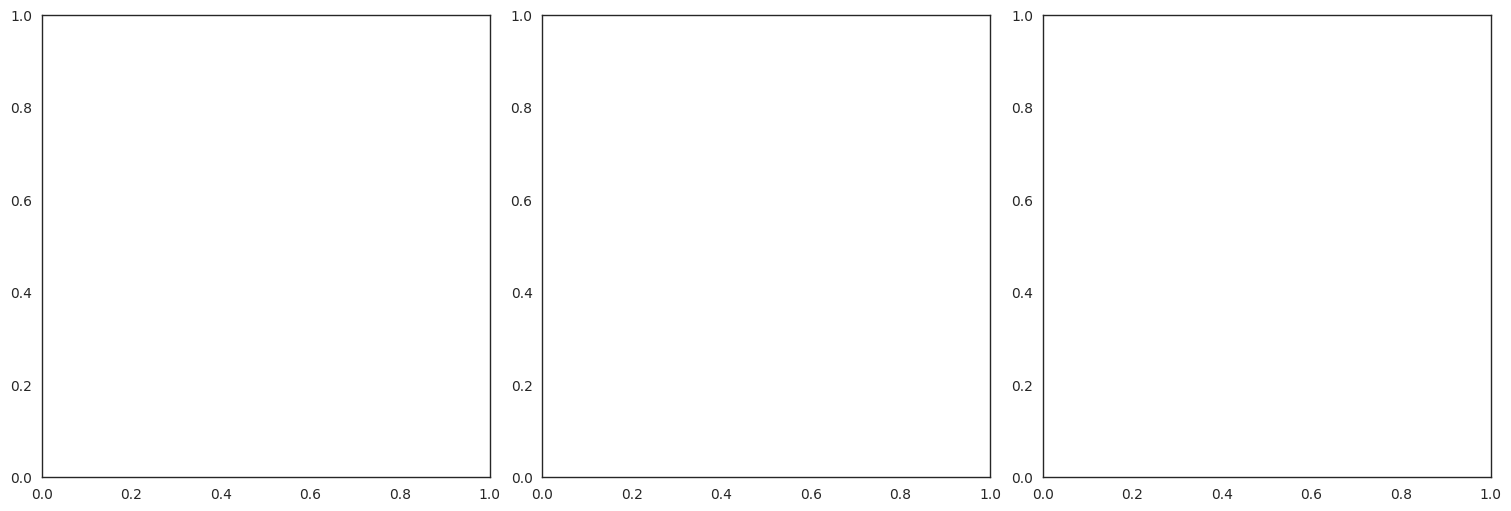

In [106]:
# Define font size
fs = 18

# Data Preparation for AUROC
col = 'interactions_auroc'
normal_data = df.loc[df.condition == 'normal', col]
tumor_data = df.loc[df.condition == 'tumor', col]

# Perform Mann-Whitney U test
u_statistic, mannwhitney_p_value = mannwhitneyu(tumor_data, normal_data, alternative='greater')

# Create the figure
fig = plt.figure(layout="constrained", figsize=(15, 5))

axs = fig.subplot_mosaic(
    """
    ABC
    """
)

lw = 3
cut = 3
alpha=0.5
bins=10


# ----- PLOT A (ROC) ------

xx = np.linspace(0,1,100)

path = '/home/lnemati/pathway_crosstalk/results/roc/tumor'
t_yy = []

for tissue in os.listdir(path):
    fpr = np.load(os.path.join(path, tissue, 'fpr.npy'))
    tpr = np.load(os.path.join(path, tissue, 'tpr.npy'))
    
    xx, yy = interpolate_data(fpr, tpr, xx)
    axs['A'].plot(xx, yy, color=tcolor, linestyle='-', lw=1, alpha=0.1)
    
    t_yy.append(yy)
    
t_median = np.median(np.array(t_yy), axis=0)

path = '/home/lnemati/pathway_crosstalk/results/roc/normal'
n_yy = []

for tissue in os.listdir(path):
    fpr = np.load(os.path.join(path, tissue, 'fpr.npy'))
    tpr = np.load(os.path.join(path, tissue, 'tpr.npy'))
    
    xx, yy = interpolate_data(fpr, tpr, xx)
    axs['A'].plot(xx, yy, color=ncolor, linestyle='-', lw=1, alpha=0.1)
    
    n_yy.append(yy)
    
n_median = np.median(np.array(n_yy), axis=0)

axs['A'].plot(coev_fpr, coev_tpr, label=f'Coevolution', color='k', lw=lw)
axs['A'].plot(xx, n_median, color=ncolor, label=f'Normal (median)', lw=lw)
axs['A'].plot(xx, t_median, color=tcolor, label=f'Tumor (median)', lw=lw)
axs['A'].plot(xx, xx, color=graycolor2, label=f'Random Classifier', lw=lw, linestyle='--')#(0, (3.33, 6.66)))

axs['A'].set_title('CCIs VS Other Gene Pairs', fontsize=1.2*fs)
axs['A'].set_xlabel('False Positive Rate', fontsize=fs)
axs['A'].set_ylabel('True Positive Rate', fontsize=fs)
axs['A'].legend(fontsize=fs)

# ----- PLOT B (TUMOR NORMAL COMPARISON) ------

sns.boxplot(x='Condition', y='interactions_auroc', data=data, palette=[ncolor, tcolor], ax=axs['B'])
axs['B'].set_title('Normal VS Tumor', fontsize=1.2*fs)
axs['B'].set_xlabel('Condition', fontsize=fs)
axs['B'].set_ylabel('AUROC', fontsize=fs)
axs['B'].set_ylim(0.5, 0.7)
axs['B'].set_yticks([0.5, 0.55, 0.6, 0.65, 0.7])

# ----- PLOT C (EXTRACELLULAR VS INTRACELLULAR) ------

# Read and filter the data
df2 = pd.read_csv('/home/lnemati/pathway_crosstalk/results/comparison/averages.csv')
#df2[df2['subtissue'] != 'testis']

df2['interaction_type'] = df2['interaction_type'].replace({
    'ccc_lr_pairs.csv': 'Cell-Cell Communication', 
    'intact_direct.csv': 'IntAct Direct',
    'intact_association.csv': 'IntAct Association',
    'intact_physical.csv': 'IntAct Physical'
})


df2 = df2.groupby(['condition', 'major_tissue', 'interaction_type', 'value_type'])['value'].mean().to_frame().reset_index()
df2 = df2.query('value_type == "average_corr"')

# Group by interaction type and condition, calculate mean and standard deviation
meandf = df2.groupby(['interaction_type', 'condition'])['value'].mean().to_frame().reset_index()
meandf['interaction_type'] = meandf['interaction_type'].apply(lambda x: x.replace('.csv', ''))

stddf = df2.groupby(['interaction_type', 'condition'])['value'].std().to_frame().reset_index()
stddf['interaction_type'] = stddf['interaction_type'].apply(lambda x: x.replace('.csv', ''))

# Define the order and align the data
order = ['Cell-Cell Communication', 'IntAct Direct', 'IntAct Physical', 'IntAct Association']
meandf = meandf.set_index('interaction_type').loc[order]
stddf = stddf.set_index('interaction_type').loc[order]

# Define the style and colors
style_normal = dict(marker='o', linestyle='--', markersize=15, linewidth=lw, markeredgewidth=2,
                    markerfacecolor=ncolor, markeredgecolor='k', color=ncolor)
style_tumor = dict(marker='o', linestyle='--', markersize=15, linewidth=lw, markeredgewidth=2,
                   markerfacecolor=tcolor, markeredgecolor='k', color=tcolor)

# Error bar customization
errorbar_kwargs = {
    'capsize': 5,
    'elinewidth': 2,
    'capthick': 2,
}

# Extract means and standard deviations
normal_means = meandf.query('condition == "normal"')['value']
normal_stds = stddf.query('condition == "normal"')['value']
tumor_means = meandf.query('condition == "tumor"')['value']
tumor_stds = stddf.query('condition == "tumor"')['value']

# Plot with error bars
axs['C'].errorbar(x=range(len(normal_means)), y=normal_means, yerr=normal_stds,
             label="Normal", **style_normal, **errorbar_kwargs)
axs['C'].errorbar(x=range(len(tumor_means)), y=tumor_means, yerr=tumor_stds,
             label="Tumor", **style_tumor, **errorbar_kwargs)

axs['C'].set_title('CCIs VS Other Interactions', fontsize=1.2*fs)
axs['C'].set_ylabel('Average Correlation', fontsize=fs)
labels = pd.Series(order).map({'Cell-Cell Communication': 'CCIs', 'IntAct Direct': 'IA Direct', 'IntAct Physical': 'IA Physical', 'IntAct Association': 'IA Association'})
axs['C'].set_xticks(range(len(order)), labels, rotation=45)

for ax in axs:
    axs[ax].spines[['right', 'top']].set_visible(False)
    axs[ax].tick_params(labelsize=fs)

# Save the figure
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/ccc_coexpr_new.pdf')#, bbox_inches='tight')
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/ccc_coexpr_new.png')#, bbox_inches='tight')

# Show the plot
plt.show()


In [60]:
fig_to_panels(fig, axs, output_dir='/home/lnemati/pathway_crosstalk/results/figures/comparison/')

Saved panel 'CCC VS Other Gene Pairs' to /home/lnemati/pathway_crosstalk/results/figures/comparison/ccc_vs_other_gene_pairs
Saved panel 'Normal VS Tumor' to /home/lnemati/pathway_crosstalk/results/figures/comparison/normal_vs_tumor
Saved panel 'CCC VS Other Interactions' to /home/lnemati/pathway_crosstalk/results/figures/comparison/ccc_vs_other_interactions


In [9]:
coev = pd.read_csv('/home/lnemati/resources/coevolution/jaccard_genes.csv.gz', index_col=0)

In [75]:
files = [
    'ccc_lr_pairs.csv',
    'intact_direct.csv',
    'intact_physical.csv',
    'intact_association.csv',
]

coev_means = {}
coev_stds   = {}

for name, file in zip(['CCIs', 'IA Direct', 'IA Physical', 'IA Association'], files):
    print(name)
    df = pd.read_csv(os.path.join('/home/lnemati/pathway_crosstalk/data/interactions', file))
    df.all_genes = df.all_genes.apply(ast.literal_eval)

    genes = set(df.all_genes.sum())
    genes = list(genes.intersection(coev.index))

    mask = df.all_genes.apply(lambda x: all([gene in genes for gene in x])) # interactions with both genes present

    pairs = pd.Index(df.loc[mask, 'all_genes'].apply(tuple).values)

    subset = coev.loc[genes, genes].stack()
    
    mean = subset.loc[pairs].mean()
    std  = subset.loc[pairs].std()
    
    coev_means[name] = mean
    stds_stds[name] = std
    
    print(mean, std)

CCIs
0.4546520731304259 0.2039862234535657
IA Direct
0.4510745822319911 0.19715428935452353
IA Physical
0.3790020854638265 0.1964927096048862
IA Association
0.3749353789012501 0.1957926002703631


In [277]:
coev_means = means
stds_stds = stds

In [37]:
df2 = pd.read_csv('/home/lnemati/pathway_crosstalk/results/comparison/averages.csv')

ERROR! Session/line number was not unique in database. History logging moved to new session 4203


In [44]:
t_df = df2.query('value_type == "average_corr" and condition == "tumor"')
ccc = t_df.loc[t_df.interaction_type == 'ccc_lr_pairs.csv', 'value']
direct = t_df.loc[t_df.interaction_type == 'intact_direct.csv', 'value']
mannwhitneyu(ccc, direct)

MannwhitneyuResult(statistic=1021.0, pvalue=8.628212667494317e-12)

In [45]:
n_df = df2.query('value_type == "average_corr" and condition == "normal"')
ccc = n_df.loc[n_df.interaction_type == 'ccc_lr_pairs.csv', 'value']
direct = n_df.loc[n_df.interaction_type == 'intact_direct.csv', 'value']
mannwhitneyu(ccc, direct)

MannwhitneyuResult(statistic=1871.0, pvalue=2.2278328719953532e-10)

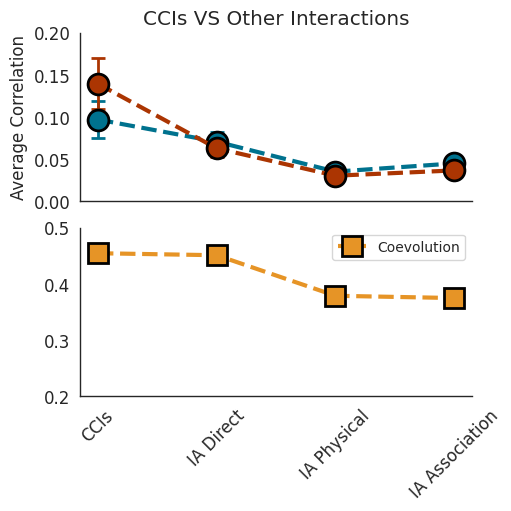

In [242]:
lw = 3

# ----- PLOT C (EXTRACELLULAR VS INTRACELLULAR) ------

# Create the figure
fig = plt.figure(layout="constrained", figsize=(5, 5))

axs = fig.subplot_mosaic(
    """
    A
    B
    """
)

# Read and filter the data
df2 = pd.read_csv('/home/lnemati/pathway_crosstalk/results/comparison/averages.csv')
#df2[df2['subtissue'] != 'testis']

df2['interaction_type'] = df2['interaction_type'].replace({
    'ccc_lr_pairs.csv': 'Cell-Cell Communication', 
    'intact_direct.csv': 'IntAct Direct',
    'intact_association.csv': 'IntAct Association',
    'intact_physical.csv': 'IntAct Physical'
})


df2 = df2.groupby(['condition', 'major_tissue', 'interaction_type', 'value_type'])['value'].mean().to_frame().reset_index()
df2 = df2.query('value_type == "average_corr"')

# Group by interaction type and condition, calculate mean and standard deviation
meandf = df2.groupby(['interaction_type', 'condition'])['value'].mean().to_frame().reset_index()
meandf['interaction_type'] = meandf['interaction_type'].apply(lambda x: x.replace('.csv', ''))

stddf = df2.groupby(['interaction_type', 'condition'])['value'].std().to_frame().reset_index()
stddf['interaction_type'] = stddf['interaction_type'].apply(lambda x: x.replace('.csv', ''))

# Define the order and align the data
order = ['Cell-Cell Communication', 'IntAct Direct', 'IntAct Physical', 'IntAct Association']
meandf = meandf.set_index('interaction_type').loc[order]
stddf = stddf.set_index('interaction_type').loc[order]

# Define the style and colors
style_normal = dict(marker='o', linestyle='--', markersize=15, linewidth=lw, markeredgewidth=2,
                    markerfacecolor=ncolor, markeredgecolor='k', color=ncolor)
style_tumor = dict(marker='o', linestyle='--', markersize=15, linewidth=lw, markeredgewidth=2,
                   markerfacecolor=tcolor, markeredgecolor='k', color=tcolor)
style_coev = dict(marker='s', linestyle='--', markersize=15, linewidth=lw, markeredgewidth=2,
                   markerfacecolor=orangecolor, markeredgecolor='k', color=orangecolor)

# Error bar customization
errorbar_kwargs = {
    'capsize': 5,
    'elinewidth': 2,
    'capthick': 2,
}

# Extract means and standard deviations
normal_means = meandf.query('condition == "normal"')['value']
normal_stds = stddf.query('condition == "normal"')['value']
tumor_means = meandf.query('condition == "tumor"')['value']
tumor_stds = stddf.query('condition == "tumor"')['value']

# Plot with error bars
axs['A'].errorbar(x=range(len(normal_means)), y=normal_means, yerr=normal_stds,
             label="Normal", **style_normal, **errorbar_kwargs)
axs['A'].errorbar(x=range(len(tumor_means)), y=tumor_means, yerr=tumor_stds,
             label="Tumor", **style_tumor, **errorbar_kwargs)
axs['B'].errorbar(x=range(len(coev_means.values())), y=list(coev_means.values()),
             label="Coevolution", **style_coev)

axs['A'].set_title('CCIs VS Other Interactions', fontsize=1.2*fs)
axs['A'].set_ylabel('Average Correlation', fontsize=fs)

for ax in axs:
    axs[ax].spines[['right', 'top']].set_visible(False)
    axs[ax].tick_params(labelsize=fs)

    
labels = pd.Series(order).map({'Cell-Cell Communication': 'CCIs', 'IntAct Direct': 'IA Direct', 'IntAct Physical': 'IA Physical', 'IntAct Association': 'IA Association'})
axs['A'].set_xticks([])
axs['B'].set_xticks(range(len(order)), labels, rotation=45)

axs['A'].set_ylim(0., 0.2)
axs['B'].set_ylim(0.2, 0.5)

plt.legend()

# Save the figure
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/ccc_coexpr_new.pdf')#, bbox_inches='tight')
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/ccc_coexpr_new.png')#, bbox_inches='tight')

# Show the plot
plt.show()


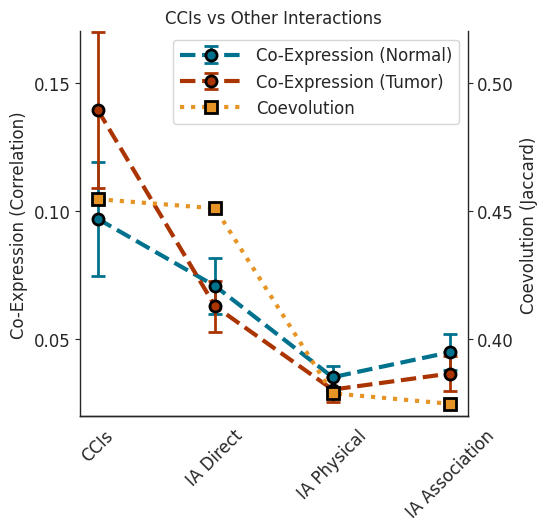

In [304]:
import matplotlib.pyplot as plt
import pandas as pd

lw = 3  # Line width
fs = 12  # Font size

# Create the figure
fig, ax1 = plt.subplots(figsize=(5, 5))
ax2 = ax1.twinx()  # Create a second y-axis

# Read and filter the data
df2 = pd.read_csv('/home/lnemati/pathway_crosstalk/results/comparison/averages.csv')
df2['interaction_type'] = df2['interaction_type'].replace({
    'ccc_lr_pairs.csv': 'Cell-Cell Communication', 
    'intact_direct.csv': 'IntAct Direct',
    'intact_association.csv': 'IntAct Association',
    'intact_physical.csv': 'IntAct Physical'
})

df2 = df2.groupby(['condition', 'major_tissue', 'interaction_type', 'value_type'])['value'].mean().reset_index()
df2 = df2.query('value_type == "average_corr" or value_type == "coevolution"')

# Group by interaction type and condition, calculate mean and standard deviation
meandf = df2.groupby(['interaction_type', 'condition'])['value'].mean().reset_index()
stddf = df2.groupby(['interaction_type', 'condition'])['value'].std().reset_index()

# Define the order and align the data
order = ['Cell-Cell Communication', 'IntAct Direct', 'IntAct Physical', 'IntAct Association']
xlabels = ['CCIs', 'IA Direct', 'IA Physical', 'IA Association']
meandf = meandf.set_index('interaction_type').loc[order]
stddf = stddf.set_index('interaction_type').loc[order]

# Extract means and standard deviations
normal_means = meandf.query('condition == "normal"')['value']
normal_stds = stddf.query('condition == "normal"')['value']
tumor_means = meandf.query('condition == "tumor"')['value']
tumor_stds = stddf.query('condition == "tumor"')['value']

# Define styles
style_normal = dict(marker='o', linestyle='--', markersize=8, linewidth=lw, markeredgewidth=2,
                    markerfacecolor=ncolor, markeredgecolor='k', color=ncolor)
style_tumor = dict(marker='o', linestyle='--', markersize=8, linewidth=lw, markeredgewidth=2,
                   markerfacecolor=tcolor, markeredgecolor='k', color=tcolor)
style_coev = dict(marker='s', linestyle=':', markersize=8, linewidth=lw, markeredgewidth=2,
                   markerfacecolor=orangecolor, markeredgecolor='k', color=orangecolor)

errorbar_kwargs = {'capsize': 5, 'elinewidth': 2, 'capthick': 2}

# Plot coevolution on ax2 first to keep it in the background
coev_plot = ax2.errorbar(x=[0,1,2,3], y=list(coev_means.values()), label="Coevolution", **style_coev)

# Plot correlation on ax1 after to ensure it is in the foreground
normal_plot = ax1.errorbar(x=range(len(normal_means)), y=normal_means, yerr=normal_stds, label="Co-Expression (Normal)", **style_normal, **errorbar_kwargs)
tumor_plot = ax1.errorbar(x=range(len(tumor_means)), y=tumor_means, yerr=tumor_stds, label="Co-Expression (Tumor)", **style_tumor, **errorbar_kwargs)

# Labels and titles
ax1.set_ylabel('Co-Expression (Correlation)', fontsize=fs)
ax2.set_ylabel('Coevolution (Jaccard)', fontsize=fs)
ax1.set_xticks(range(len(order)))
ax1.set_xticklabels(xlabels, rotation=45, fontsize=fs)
ax1.set_ylim(0.02, 0.17)
ax2.set_ylim(0.37, 0.52)
ax1.set_title('CCIs vs Other Interactions', fontsize=fs)

ax1.tick_params(labelsize=fs)
ax2.tick_params(labelsize=fs)

ax1.set_yticks([0.05, 0.1, 0.15])
ax2.set_yticks([0.4, 0.45, 0.5])

# Hide unnecessary spines
ax1.spines[['right', 'top']].set_visible(False)
ax2.spines[['left', 'top']].set_visible(False)

# Create combined legend to ensure correct linestyles
handles = [normal_plot, tumor_plot, coev_plot]
labels = [h.get_label() for h in handles]
ax1.legend(handles, labels, loc='upper right', fontsize=fs, handlelength=3.8)

# Save the figure
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/ccs_vs_intracellular.pdf', dpi=300, bbox_inches='tight')
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/ccs_vs_intracellular.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()


In [308]:
np.dot([1,2,3], [2,-1,6]).min()

18

# Pathway Network

In [17]:
network = pd.read_csv('/home/lnemati/pathway_crosstalk/results/pathways_network/pathways_network_filtered.csv')
all_pathways = list(set(network['pathway1']).union(set(network['pathway2'])))

In [18]:
len(all_pathways)

169

In [21]:
# Replace 'inf' values with the maximum value
max_value = network.log2_odds_ratio.replace([float('inf'), float('-inf')], float('nan')).max().max()
min_value = network.log2_odds_ratio.replace([float('inf'), float('-inf')], float('nan')).min().min()

network['log2_odds_ratio'] = network['log2_odds_ratio'].replace(float('inf'), max_value)
network['log2_odds_ratio'] = network['log2_odds_ratio'].replace(float('-inf'), min_value)

In [22]:
network.to_csv('/home/lnemati/pathway_crosstalk/results/pathways_network/pathways_network_no_inf.csv')

In [23]:
roots = pd.read_csv('/home/lnemati/resources/reactome/ReactomeRootPathways.csv')
roots.set_index('pathway', inplace=True)

In [24]:
# Get id-name mapping
ids = pd.read_csv('/home/lnemati/resources/reactome/ReactomeIDs.tsv', sep='\t', names=['name', 'id'])
ids2names = ids.set_index('id')
names2ids = ids.set_index('name')

In [25]:
# Subset
ids = names2ids.loc[all_pathways, 'id'].values
roots = roots.loc[ids]

In [26]:
names = ids2names.loc[roots['root']].name
roots['root'] = names.values

In [27]:
names = ids2names.loc[roots.index].name
roots.index = names.values

In [28]:
roots.loc[network.pathway1]['root']

TNF receptor superfamily (TNFSF) members mediating non-canonical NF-kB pathway                        Immune System
TNFs bind their physiological receptors                                                               Immune System
RUNX1 and FOXP3 control the development of regulatory T lymphocytes (Tregs)         Gene expression (Transcription)
RUNX1 and FOXP3 control the development of regulatory T lymphocytes (Tregs)         Gene expression (Transcription)
Interleukin-15 signaling                                                                              Immune System
                                                                                                ...                
HSF1 activation                                                                       Cellular responses to stimuli
HSF1 activation                                                                       Cellular responses to stimuli
Purinergic signaling in leishmaniasis infection                         

In [29]:
roots.root.value_counts()

Immune System                           35
Disease                                 30
Signal Transduction                     24
Developmental Biology                   15
Metabolism of proteins                  15
Extracellular matrix organization       10
Metabolism                               8
Neuronal System                          7
Gene expression (Transcription)          7
Hemostasis                               7
Vesicle-mediated transport               7
Cellular responses to stimuli            4
Organelle biogenesis and maintenance     1
Cell-Cell communication                  1
Circadian Clock                          1
Muscle contraction                       1
Name: root, dtype: int64

In [30]:
multiple_roots = roots.index.value_counts()[roots.index.value_counts() > 1].index
roots.loc[multiple_roots, 'root'] = 'Multiple root pathways'

In [31]:
roots.loc[network.pathway1]['root'].values.shape

(788,)

In [32]:
for idx, row in network.iterrows():
    if roots.loc[row.pathway1].shape[0] == 1:
        network.at[idx, 'root1'] = roots.loc[row.pathway1]['root']
    else:
        network.at[idx, 'root1'] = 'Multiple roots'
        
    if roots.loc[row.pathway2].shape[0] == 1:
        network.at[idx, 'root2'] = roots.loc[row.pathway2]['root']
    else:
        network.at[idx, 'root2'] = 'Multiple roots'

network.to_csv('/home/lnemati/pathway_crosstalk/results/pathways_network/pathways_network_no_inf.csv', index=False)

In [33]:
roots.index.name = 'pathway'
network.to_csv('/home/lnemati/pathway_crosstalk/results/pathways_network/pathways_network_no_inf.csv', index=False)

In [34]:
roots = roots.reset_index().drop_duplicates().set_index('pathway')
roots.to_csv('/home/lnemati/pathway_crosstalk/results/pathways_network/pathways_roots.csv')

In [35]:
network['root2'].unique()

array(['Developmental Biology', 'Immune System', 'Signal Transduction',
       'Extracellular matrix organization', 'Metabolism of proteins',
       'Hemostasis', 'Disease', 'Metabolism',
       'Gene expression (Transcription)', 'Circadian Clock',
       'Multiple roots', 'Cellular responses to stimuli',
       'Vesicle-mediated transport', 'Neuronal System',
       'Organelle biogenesis and maintenance'], dtype=object)

In [38]:
subset = roots[roots['root'] == 'Neuronal System']
subset

,root
pathway,
Assembly and cell surface presentation of NMDA receptors,Neuronal System
Negative regulation of NMDA receptor-mediated neuronal transmission,Neuronal System
Dopamine Neurotransmitter Release Cycle,Neuronal System
Long-term potentiation,Neuronal System
Neurexins and neuroligins,Neuronal System
"Unblocking of NMDA receptors, glutamate binding and activation",Neuronal System
Acetylcholine Neurotransmitter Release Cycle,Neuronal System


In [44]:
edgelist = network[['pathway1', 'pathway2', 'log2_odds_ratio']]
edgelist

,pathway1,pathway2,log2_odds_ratio
0,TNF receptor superfamily (TNFSF) members media...,Other semaphorin interactions,5.569856
1,TNFs bind their physiological receptors,TNF receptor superfamily (TNFSF) members media...,5.569856
2,RUNX1 and FOXP3 control the development of reg...,Interleukin receptor SHC signaling,4.321928
3,RUNX1 and FOXP3 control the development of reg...,Interleukin-15 signaling,3.797956
4,Interleukin-15 signaling,Interleukin receptor SHC signaling,3.767554
...,...,...,...
780,HSF1 activation,Defective B3GALT6 causes EDSP2 and SEMDJL1,-8.240314
781,HSF1 activation,Defective B3GAT3 causes JDSSDHD,-8.240314
782,Purinergic signaling in leishmaniasis infection,Attenuation phase,-8.240314
783,Signaling by FGFR2 IIIa TM,Cross-presentation of particulate exogenous an...,-8.240314


In [45]:
# Gather all unique pathway names
all_pathways = list(set(edgelist['pathway1']).union(set(edgelist['pathway2'])))

# Create an empty DataFrame with pathways as both index and columns
adjacency_matrix = pd.DataFrame(0, index=all_pathways, columns=all_pathways)

# Iterate over each row in the DataFrame and update the adjacency matrix
for index, row in edgelist.iterrows():
    pathway1 = row['pathway1']
    pathway2 = row['pathway2']
    log2_odds_ratio = row['log2_odds_ratio']
    
    adjacency_matrix.loc[pathway1, pathway2] = log2_odds_ratio
    adjacency_matrix.loc[pathway2, pathway1] = log2_odds_ratio  # Assuming the graph is undirected
    
# Replace 'inf' values with 10 times the maximum value
max_value = adjacency_matrix.replace([float('inf'), float('-inf')], float('nan')).max().max()
adjacency_matrix = adjacency_matrix.replace(float('inf'), max_value)

# Replace '-inf' values with 10 times the minimum value
min_value = adjacency_matrix.replace([float('inf'), float('-inf')], float('nan')).min().min()
adjacency_matrix = adjacency_matrix.replace(float('-inf'), min_value)

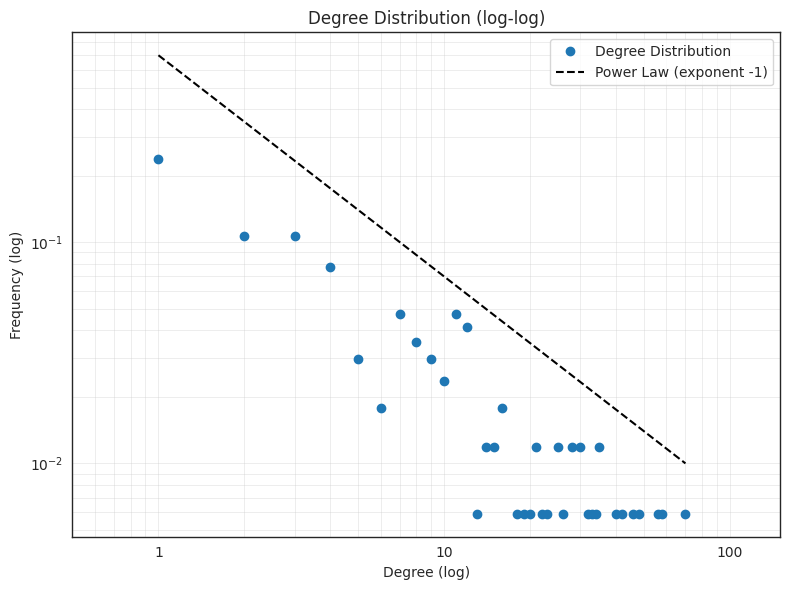

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Assuming you already have the adjacency matrix stored in 'adjacency_matrix'

# Calculate the degrees
degrees = np.abs(adjacency_matrix != 0).sum(axis=1)

degree_counts = (degrees.value_counts() / adjacency_matrix.shape[0]).values
degree_idx = degrees.value_counts().index

# Plot on log-log scale
plt.figure(figsize=(8, 6))
plt.plot(degree_idx, degree_counts, linestyle=' ', marker='o', label='Degree Distribution')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree (log)')
plt.ylabel('Frequency (log)')
plt.xlim(0.5, 150)
plt.grid(which='both', linestyle='-', linewidth=0.5, alpha=0.5)
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.title('Degree Distribution (log-log)')

# Add a line for the theoretical power law with exponent -1
x_values = np.linspace(min(degree_idx), max(degree_idx), 100)
y_values = 0.7 * x_values ** (-1)  # Adjust the constant for visualization
plt.plot(x_values, y_values, color='k', linestyle='--', label='Power Law (exponent -1)')

plt.legend()
plt.tight_layout()

# Save the plot
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/pathways_network/degree_distribution.pdf')

plt.show()


In [50]:
degrees.sort_values(ascending=False)

Neutrophil degranulation                                                    70
Immunoregulatory interactions between a Lymphoid and a non-Lymphoid cell    58
Interleukin-4 and Interleukin-13 signaling                                  56
ECM proteoglycans                                                           48
Integrin cell surface interactions                                          46
                                                                            ..
CD28 dependent Vav1 pathway                                                  1
Adrenaline,noradrenaline inhibits insulin secretion                          1
E3 ubiquitin ligases ubiquitinate target proteins                            1
Negative regulation of NMDA receptor-mediated neuronal transmission          1
TNFs bind their physiological receptors                                      1
Length: 169, dtype: int64

# High level pathways

In [5]:
network = pd.read_csv('/home/lnemati/pathway_crosstalk/results/pathways_network/pathways_network_filtered.csv')

In [8]:
adj = pd.read_csv('/home/lnemati/pathway_crosstalk/results/pathways_network/pathways_high_level_adjacency.csv', index_col=0)

In [9]:
ranked = stack_triangle(adj, 'n')

In [10]:
df = ranked.sort_values(by='n', ascending=False)
df = df[df['n'] > 0]
df.shape

(66, 1)

In [11]:
# Reset index to explode
exploded_df = df.reset_index()

# Rename columns
exploded_df.columns = ['Level 1', 'Level 2', 'n']

for elem in exploded_df['Level 1'] + '-' + exploded_df['Level 2'] + ': ' + exploded_df['n'].astype(int).astype(str):
    print(elem)

Immune System-Disease: 74
Immune System-Extracellular matrix organization: 62
Metabolism of proteins-Immune System: 47
Signal Transduction-Extracellular matrix organization: 44
Disease-Extracellular matrix organization: 35
Disease-Signal Transduction: 33
Signal Transduction-Developmental Biology: 33
Immune System-Signal Transduction: 31
Immune System-Developmental Biology: 30
Metabolism of proteins-Signal Transduction: 23
Metabolism of proteins-Extracellular matrix organization: 22
Extracellular matrix organization-Developmental Biology: 20
Vesicle-mediated transport-Immune System: 16
Gene expression (Transcription)-Immune System: 15
Cellular responses to stimuli-Immune System: 15
Cellular responses to stimuli-Extracellular matrix organization: 15
Metabolism of proteins-Developmental Biology: 14
Disease-Hemostasis: 14
Cellular responses to stimuli-Signal Transduction: 13
Extracellular matrix organization-Hemostasis: 13
Cellular responses to stimuli-Disease: 13
Immune System-Metabolism:

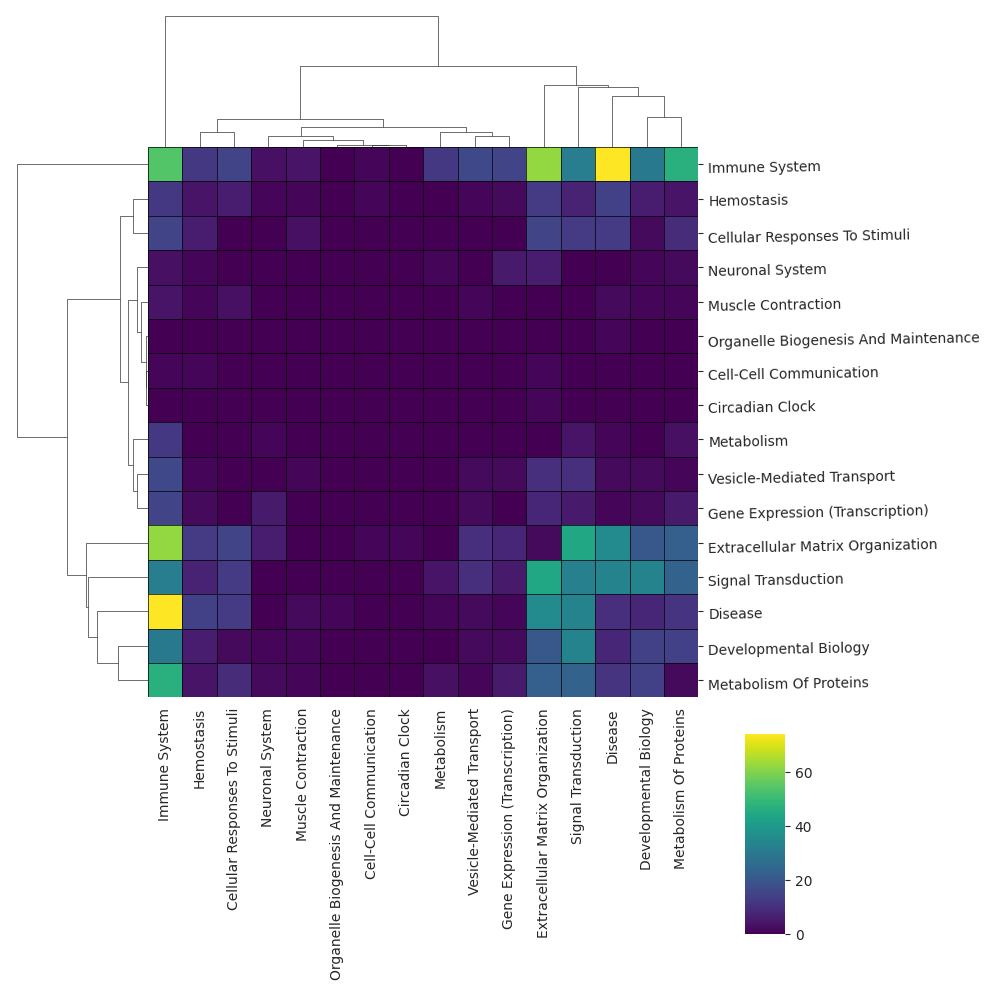

In [12]:
matrix = adj

matrix.columns = [col.title() for col in matrix.columns]
matrix.index   = [idx.title() for idx in matrix.index  ]

g = sns.clustermap(
    adj,
    cmap='viridis',
    cbar_pos=(.75, .06, .04, .2),
    figsize=(10, 10),
    #row_cluster=False,
    #col_cluster=False,
    #row_colors=row_colors,
    #colors_ratio=1/(2*len(all_roots)),
    #vmin=-1.1,
    #vmax=1.1
)

g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=1)  # Adjust the rotation as needed

# Add black outline
separators1 = list(range(matrix.shape[1]))
separators1 = separators1 + [max(separators1) + 0.99]
separators2 = list(range(matrix.shape[0]))
separators2 = separators2 + [max(separators2) + 0.99]
g.ax_heatmap.vlines(separators1, *g.ax_heatmap.get_ylim(), color='k', linewidth=0.5, zorder=1)
g.ax_heatmap.hlines(separators2, *g.ax_heatmap.get_xlim(), color='k', linewidth=0.5, zorder=1)

plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/pathways_network/high_lev_heathmap.pdf', bbox_inches="tight")

# Consensus Modules Enrichment

In [21]:
conditions = ('tumor', 'normal')
quantiles = ('perc25', 'median')

for condition in conditions:
    for quantile in quantiles:
        print(condition, quantile)
        enr = pd.read_csv(f'/home/lnemati/pathway_crosstalk/results/consensus_modules/{condition}/{quantile}/enrichment.csv')
        for module, df in enr.groupby('module'):
            top3 = df.sort_values(by='Adjusted P-value', ascending=True).head(3).Term.values.tolist()
            print(module, top3)
        print()

tumor perc25
0 ['Neuronal System', 'Sensory Perception', 'Metabolism of lipids']
1 ['Chromatin modifying enzymes', 'Chromatin organization', 'Gene expression (Transcription)']
2 ['Immune System', 'Innate Immune System', 'Adaptive Immune System']
3 ['Respiratory electron transport, ATP synthesis by chemiosmotic coupling, and heat production by uncoupling proteins.', 'Aerobic respiration and respiratory electron transport', 'Respiratory electron transport']
4 ['Complex I biogenesis', 'Respiratory electron transport', 'Respiratory electron transport, ATP synthesis by chemiosmotic coupling, and heat production by uncoupling proteins.']
5 ['Cell Cycle', 'Cell Cycle, Mitotic', 'Cell Cycle Checkpoints']
6 ['Signal Transduction', 'Extracellular matrix organization', 'Integrin cell surface interactions']
7 ['Gluconeogenesis', 'Cytosolic iron-sulfur cluster assembly', 'Glucose metabolism']
8 ['Eukaryotic Translation Elongation', 'Peptide chain elongation', 'Formation of a pool of free 40S subuni

In [5]:
adata = sc.read_h5ad('/projects/bioinformatics/DB/Xena/TCGA_GTEX/TCGA_GTEX.h5ad')

print("Subsetting samples")

rename = {
    "X_study": "study",
    "X_gender": "gender",
    "X_sample_type": "type",
    "X_primary_site": "tissue",
    "primary_disease_or_tissue": "condition"
}

adata.obs.rename(columns=rename, inplace=True)
adata.obs.drop(columns="detailed_category", inplace=True)

adata = adata[adata.obs.type.isin(["Primary Tumor", "Normal Tissue"])]


Subsetting samples


In [6]:
# retrieve gene symbol of protein coding genes                                                                                
annot = pd.read_csv("~/resources/biomart/ensembl_to_symbol_filtered.csv.gz", index_col="Gene stable ID")                      
                                                                                                                              
# remove ensembl version                                                                                                      
adata.var["ensembl"] = adata.var_names.str.replace(r"\..*","", regex=True)                                                    
adata.var_names = adata.var["ensembl"].values                                                                                 
                                                                                                                              
# subset to genes in biomart                                                                                                  
adata = adata[:, adata.var_names.isin(annot.index)]                                                                           
                                                                                                                              
# add gene symbols                                                                                                            
adata.var["symbol"] = annot["Gene name"]                                                                                      
                                                                                                                              
# remove genes with missing symbol                                                                                            
adata = adata[:, ~adata.var.symbol.isna()]                                                                                    
                                                                                                                              
# set index to gene symbol                                                                                                    
adata.var_names = adata.var.symbol.values 

In [7]:
modules = pd.read_csv('/home/lnemati/pathway_crosstalk/results/consensus_modules/tumor/median/consensus_modules.csv', index_col=0)

In [8]:
genes = modules.index

In [9]:
adata = adata[:, genes]

In [ ]:
adata.var['module'] = modules['module']

In [1]:
adata

NameError: name 'adata' is not defined

# Motifs_TEST

In [14]:
columns = ['3_path', '3_clique', '4_no_crosstalk', '4_path', '4_triangle_extra', '4_cycle', '4_one_missing', '4_clique']

nfolder = '/home/lnemati/pathway_crosstalk/results/crosstalk/motifs_per_tissue/normal'
tissues = os.listdir(nfolder)
ndf = pd.DataFrame(index=tissues, columns=columns)
for tissue in tissues:
    folder = os.path.join(nfolder, tissue)
    
    df     = pd.read_csv(os.path.join(folder, 'motifs_permutations.csv'))
    counts = pd.read_csv(os.path.join(folder, 'counts.csv'), index_col='motif')['counts']

    mean = (df.T / df.sum(1)).T.mean()
    std = (df.T / df.sum(1)).T.std()

    # Get mean ans std
    freqs = counts / counts.sum()
    z = (freqs - mean) / std
    
    
    ndf.loc[tissue] = z
    
ndf['condition'] = 'Normal'

tfolder = '/home/lnemati/pathway_crosstalk/results/crosstalk/motifs_per_tissue/tumor'
tissues = os.listdir(tfolder)
tdf = pd.DataFrame(index=tissues, columns=columns)
for tissue in tissues:
    folder = os.path.join(tfolder, tissue)
    
    df     = pd.read_csv(os.path.join(folder, 'motifs_permutations.csv'))
    counts = pd.read_csv(os.path.join(folder, 'counts.csv'), index_col='motif')['counts']

    mean = (df.T / df.sum(1)).T.mean()
    std = (df.T / df.sum(1)).T.std()

    # Get mean ans std
    freqs = counts / counts.sum()
    z = (freqs - mean) / std
    
    
    tdf.loc[tissue] = z
    
tdf['condition'] = 'Tumor'

df = pd.concat([ndf, tdf])

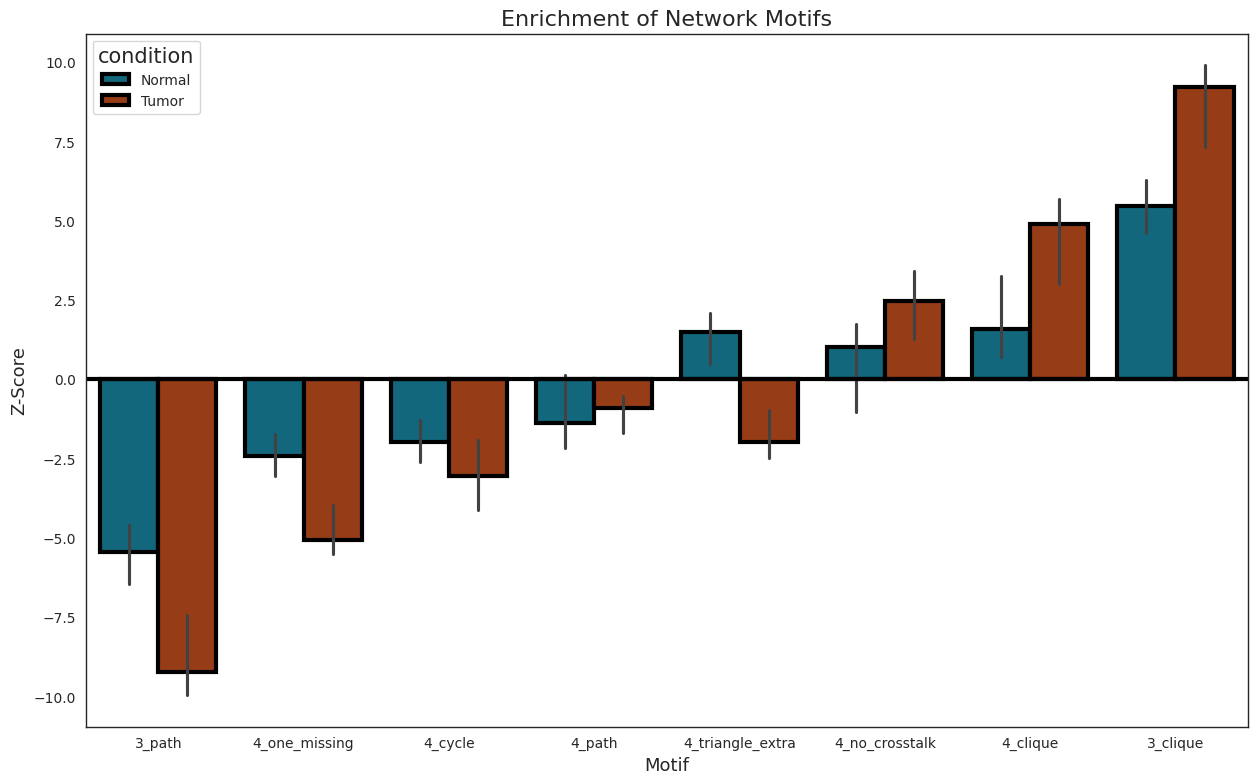

<Figure size 1200x600 with 0 Axes>

In [18]:
import os
import pandas as pd

columns = ['3_path', '3_clique', '4_no_crosstalk', '4_path', '4_triangle_extra', '4_cycle', '4_one_missing', '4_clique']

# Function to process tissues in a folder
def process_tissues(folder, condition):
    tissues = os.listdir(folder)
    df = pd.DataFrame(index=tissues, columns=columns)

    for tissue in tissues:
        tissue_folder = os.path.join(folder, tissue)

        perm_df = pd.read_csv(os.path.join(tissue_folder, 'motifs_permutations.csv'))
        counts = pd.read_csv(os.path.join(tissue_folder, 'counts.csv'), index_col='motif')['counts']

        # Normalize columns starting with '3' and '4' separately
        perm_normalized = perm_df.copy()
        perm_normalized[[col for col in columns if col.startswith('3')]] /= perm_df[[col for col in columns if col.startswith('3')]].sum(axis=1).values[:, None]
        perm_normalized[[col for col in columns if col.startswith('4')]] /= perm_df[[col for col in columns if col.startswith('4')]].sum(axis=1).values[:, None]

        counts_normalized = counts.copy()
        counts_normalized[[col for col in columns if col.startswith('3')]] /= counts[[col for col in columns if col.startswith('3')]].sum()
        counts_normalized[[col for col in columns if col.startswith('4')]] /= counts[[col for col in columns if col.startswith('4')]].sum()

        mean = perm_normalized.mean()
        std = perm_normalized.std()

        # Calculate frequencies and z-scores
        z = (counts_normalized - mean) / std

        df.loc[tissue] = z

    df['condition'] = condition
    return df

nfolder = '/home/lnemati/pathway_crosstalk/results/crosstalk/motifs_per_tissue/normal'
tfolder = '/home/lnemati/pathway_crosstalk/results/crosstalk/motifs_per_tissue/tumor'

ndf = process_tissues(nfolder, 'Normal')
tdf = process_tissues(tfolder, 'Tumor')

# Combine the dataframes
df = pd.concat([ndf, tdf])
ndf = ndf.drop(columns = 'condition').apply(pd.to_numeric, errors='coerce')
tdf = tdf.drop(columns = 'condition').apply(pd.to_numeric, errors='coerce')

df.index.name = 'tissue'
df = df.reset_index()

fs = 13

fig, ax = plt.subplots(1, 1, figsize=(15, 9))

# Melt the DataFrame to make it easier for seaborn to handle
melted_df = df.melt(id_vars=["condition", 'tissue'], var_name="Motif", value_name="Z-Score")
order = melted_df.groupby('Motif')['Z-Score'].median().sort_values().index

# Create the violin plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=melted_df,
    x="Motif", 
    y="Z-Score",
    hue="condition",
    estimator='median',
    errorbar='ci',
    order=order,
    palette={'Normal': ncolor, 'Tumor': tcolor},
    ax=ax,
    edgecolor='k',
    linewidth=3,
)

xlim = ax.get_xlim()
#ax.hlines(1.645, xlim[0], xlim[1], color='k', linestyle='--', linewidth=3) # Corresponds to p = 0.05 for a normal distribution
ax.hlines(0, xlim[0], xlim[1], color='k', linestyle='-', linewidth=3)
ax.set_xlim(xlim[0], xlim[1])

# Customize plot
ax.set_title("Enrichment of Network Motifs", fontsize=16)
ax.set_xlabel("Motif", fontsize=fs)
ax.set_ylabel("Z-Score", fontsize=fs)

tumor_motifs_z = melted_df.query('condition == "Tumor"').drop(columns='condition')


In [25]:
directory = '/home/lnemati/pathway_crosstalk/results/crosstalk/motifs_per_tissue/tumor/'
filename = 'survival.csv'

filepaths = []
for root, dirs, files in os.walk(directory):
    if filename in files:
        filepaths.append(os.path.join(root, filename))
        
dfs = []
rawdfs = []

MIN_PATIENTS = 10

def extract_values(col):  
    df[col]     = rawdf.loc[crosstalks, col].values
    df[col+'1'] = rawdf.loc[int1,       col].values
    df[col+'2'] = rawdf.loc[int2,       col].values

for file in filepaths:
    normal_path = file.replace('/survival.csv', '').replace('/tumor/', '/normal/')
    if not os.path.exists(normal_path):
        continue
    
    rawdf = pd.read_csv(file, index_col='interaction')
    tmotifs = pd.read_csv(file.replace('survival.csv', 'motifs.csv'), index_col='interaction')
    rawdf.loc[rawdf.type == 'ccc', 'tumor_motif'] = 'ccc'
    rawdf.loc[rawdf.index.intersection(tmotifs.index), 'tumor_motif'] = tmotifs.loc[rawdf.index.intersection(tmotifs.index), 'motif']

    nmotifs = pd.read_csv(file.replace('/tumor/', '/normal/').replace('survival.csv', 'motifs.csv'), index_col='interaction')
    rawdf.loc[rawdf.type == 'ccc', 'normal_motif'] = 'ccc'
    rawdf.loc[rawdf.index.intersection(nmotifs.index), 'normal_motif'] = nmotifs.loc[rawdf.index.intersection(nmotifs.index), 'motif']
    
    #rawdf = rawdf.dropna()
    tissue = file.split('/')[-2]
    print(tissue)
    
    rawdf['tissue'] = tissue
    rawdfs.append(rawdf)
    
    crosstalks = rawdf.query('(type == "crosstalk")').index
    
    if len(crosstalks) == 0:
        continue
    
    int1 = crosstalks.str.split('&', expand=True).get_level_values(0)
    int2 = crosstalks.str.split('&', expand=True).get_level_values(1)
    
    df = pd.DataFrame(index=crosstalks)

    cols = [
        'hr',
        'ci_low',
        'ci_high',
        'se',
        'n_patients_low',
        'n_patients_high',
        'logrank_pval',
        'concordance_index',
        'tissue'
    ]
    
    for col in cols:
        extract_values(col)
    
    df = df.drop(columns=['tissue1', 'tissue2']) 
    
    df['min_patients']  = df[['n_patients_low', 'n_patients_high']].min(1)
    df['min_patients1'] = df[['n_patients_low1', 'n_patients_high2']].min(1)
    df['min_patients2'] = df[['n_patients_low1', 'n_patients_high2']].min(1)
    
    df = df.drop(columns=['n_patients_low', 'n_patients_low1', 'n_patients_low2']) 
    df['tumor_motif'] = tmotifs.loc[df.index, 'motif'].values
    df['tumor_motif'] = df['tumor_motif'].fillna('None')

    df.loc[df.index.intersection(nmotifs.index), 'normal_motif'] = nmotifs.loc[df.index.intersection(nmotifs.index), 'motif']
    df['normal_motif'] = df['normal_motif'].fillna('None')

    dfs.append(df)

rawdf =  pd.concat(rawdfs).reset_index().set_index(['interaction', 'tissue'])
crosstalkdf = pd.concat(dfs).reset_index().set_index(['interaction', 'tissue'])

crosstalkdf['log2_hr'] = np.log2(crosstalkdf['hr'])
crosstalkdf['log2_hr1'] = np.log2(crosstalkdf['hr1'])
crosstalkdf['log2_hr2'] = np.log2(crosstalkdf['hr2'])

valid = crosstalkdf.dropna().query('(min_patients > @MIN_PATIENTS) and (min_patients1 > @MIN_PATIENTS) and (min_patients2 > @MIN_PATIENTS)').index

rawdf.loc[valid, 'pval_adj'] = false_discovery_control(rawdf.loc[valid, 'logrank_pval'])
crosstalkdf.loc[valid, 'pval_adj'] = rawdf.loc[valid, 'pval_adj']
crosstalkdf = crosstalkdf.loc[valid]

crosstalkdf = crosstalkdf.sort_values(by='pval_adj')
crosstalkdf['hr_lfc_best'] =  crosstalkdf['log2_hr'].abs() - crosstalkdf[['log2_hr1', 'log2_hr2']].abs().max(1)
crosstalkdf['c_diff_best'] =  crosstalkdf['concordance_index'].abs() - crosstalkdf[['concordance_index1', 'concordance_index2']].abs().max(1)

crosstalkdf = crosstalkdf.reset_index()
rawdf = rawdf.reset_index()

crosstalkdf.sort_values(by='concordance_index', ascending=False, inplace=True)

#crosstalkdf.to_csv('/home/lnemati/pathway_crosstalk/results/survival/motifs_survival_all.csv')

#significant = significant[~((significant['ci_low'] < 1)                   & (1 < significant['ci_high']))]
#significant = significant[~((significant['ci_low'] < significant['hr1']) & (significant['hr1'] < significant['ci_high']))]
#significant = significant[~((significant['ci_low'] < significant['hr2']) & (significant['hr2'] < significant['ci_high']))]

del dfs, df

uterus
kidney
adrenal_gland
liver
prostate
lung
breast
ovary
skin
pancreas
thyroid
colon
esophagus
stomach


In [21]:
#crosstalkdf = crosstalkdf.query('normal_motif in ["4_no_crosstalk", "None"]')
####crosstalkdf.query('tumor_motif in ["4_clique", "3_clique"] and normal_motif in ["4_no_crosstalk", "None"]')

In [23]:
#rawdf = pd.read_csv('/home/lnemati/pathway_crosstalk/results/survival/aggregate/all_unfiltered.csv')
#crosstalkdf = pd.read_csv('/home/lnemati/pathway_crosstalk/results/survival/aggregate/all_pairs.csv')
#better = pd.read_csv('/home/lnemati/pathway_crosstalk/results/survival/aggregate/better_pairs.csv')
#subset = subset.query('hr_lfc_best > 0.58 and concordance_index > 0.7')


#subset = better.query('motif in ["3_clique", "4_clique"] and min_patients >= 30')
#subset = subset.query('not ((hr - se) < 1 and 1 < (hr + se))')

In [26]:
significant = crosstalkdf.query('pval_adj < 0.05')
significant = significant.query('not ((hr - se) < 1 and 1 < (hr + se))')

better = significant.copy()
better = better.query('hr_lfc_best > 0.')
better = better.query('c_diff_best > 0.')
better = better.query('(logrank_pval < logrank_pval1) and (logrank_pval < logrank_pval2)')

In [27]:
better

,interaction,tissue,hr,hr1,hr2,ci_low,ci_low1,ci_low2,ci_high,ci_high1,...,min_patients1,min_patients2,tumor_motif,normal_motif,log2_hr,log2_hr1,log2_hr2,pval_adj,hr_lfc_best,c_diff_best
133240,ERBB2_ERBB3+NRG1&FZD7_LRP5+WNT10A,breast,0.048299,0.887026,1.155548,0.004878,0.508002,0.726594,0.478207,1.548841,...,193,193,4_one_missing,None,-4.371862,-0.172952,0.208577,0.008706,4.163285,0.321517
73136,IGF1R+IGF2&CD74_CXCR4+MIF,breast,0.039895,0.894036,0.393508,0.004522,0.609002,0.224264,0.351986,1.312474,...,189,189,4_triangle_extra,None,-4.647661,-0.161596,-1.345534,0.001614,3.302128,0.268239
167386,GLS2_SLC17A7+GRIN1_GRIN2C&IL2RG_IL7R+IL7,breast,0.095028,1.338618,0.768325,0.018253,0.704898,0.525579,0.494723,2.542066,...,124,124,4_no_crosstalk,None,-3.395510,0.420744,-0.380211,0.015640,2.974766,0.276527
54752,NECTIN1+NECTIN3&NRP1+PGF,adrenal_gland,16.535086,8.532047,7.908575,3.384078,2.415889,2.231142,80.792787,30.132115,...,26,26,4_path,4_one_missing,4.047459,3.092892,2.983418,0.000680,0.954567,0.056841
26177,COL8A1+ITGA2_ITGB1&LRFN4+PTPRF,adrenal_gland,19.842908,7.520978,12.078501,4.237849,2.398059,2.747050,92.910567,23.587878,...,22,22,4_one_missing,None,4.310552,2.910920,3.594369,0.000066,0.716182,0.051666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256835,ICAM1+SPN&FGFR1+NCAM1,kidney,2.078049,1.036422,1.182935,1.288355,0.861372,0.966419,3.351784,1.247047,...,900,900,4_no_crosstalk,None,1.055230,0.051612,0.242371,0.042367,0.812858,0.001871
178309,ICAM1+SPN&LRFN4+PTPRF,lung,1.840856,1.222187,1.015911,1.277649,1.026812,0.846288,2.652334,1.454736,...,714,714,4_no_crosstalk,None,0.880377,0.289465,0.022774,0.018258,0.590912,0.003285
274575,COL6A3+ITGA1_ITGB1&ITGA2_ITGB1+LAMA5,kidney,2.136669,1.029083,1.014235,1.277721,0.790439,0.768004,3.573044,1.339776,...,507,507,4_one_missing,4_one_missing,1.095363,0.041359,0.020392,0.048800,1.054004,0.015724
274576,COL6A3+ITGA2_ITGB1&ITGA1_ITGB1+LAMA5,kidney,2.136669,1.158968,1.147801,1.277721,0.880638,0.867289,3.573044,1.525264,...,498,498,4_one_missing,4_one_missing,1.095363,0.212840,0.198872,0.048800,0.882523,0.002999


In [28]:
#z = tumor_motifs_z.set_index(['tissue', 'Motif'])['Z-Score']
z = tumor_motifs_z.groupby('Motif')['Z-Score'].median().sort_values()
counts = better['tumor_motif'].value_counts()
all_counts = crosstalkdf['tumor_motif'].value_counts()
probs = (counts / all_counts).dropna()

In [29]:
probs = probs.loc[z.index.intersection(probs.index)]
z = z.loc[z.index.intersection(probs.index)]

probs
PearsonRResult(statistic=0.20970332924586527, pvalue=0.6181814399917414)


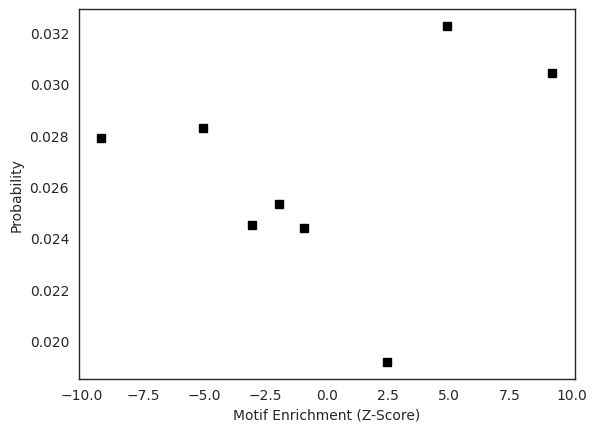

In [30]:
from scipy.stats import sem, pearsonr,spearmanr
import matplotlib.pyplot as plt

#df = better#.query('(pval_adj < 0.05)')
#all_counts = crosstalkdf.motif.value_counts().sort_values(ascending=False)

#probs = (df.motif.value_counts() / all_counts).sort_values()

#z = tumor_motifs_z.sort_values()
#probs = probs.reindex(z.index)

# Plot the results
print('probs')
print(pearsonr(probs, z))
#plt.title('Probability of motif stratifying well in general (logrank pval <0.05)')
plt.xlabel('Motif Enrichment (Z-Score)')
plt.ylabel('Probability')
plt.errorbar(z, probs, linestyle=' ', marker='s', color='k')  # Add error bars
plt.show()


# T Same / N Diff. & N Same / T Diff.

In [44]:
#bkg = '_with_background'
bkg = '_without_background'

# Liver
t_enr = pd.read_csv('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/liver/tumor/liver_hepatocellular_carcinoma/t_same_n_diff_enrichr'+bkg+'.csv')
t_enr = t_enr[t_enr['Adjusted P-value'] < 0.01]
#t_enr = t_enr.sort_values(by='Odds Ratio')
t_enr = t_enr.sort_values(by='P-value', ascending=False)
t_enr['Log Odds Ratio'] = np.log2(t_enr['Odds Ratio'])

n_enr = pd.read_csv('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/liver/tumor/liver_hepatocellular_carcinoma/n_same_t_diff_enrichr'+bkg+'.csv')
n_enr = n_enr[n_enr['Adjusted P-value'] < 0.01]
#n_enr = n_enr.sort_values(by='Odds Ratio')
n_enr = n_enr.sort_values(by='P-value', ascending=False)
n_enr['Log Odds Ratio'] = np.log2(n_enr['Odds Ratio'])


In [45]:
print(t_enr.shape)
print(n_enr.shape)

(80, 8)
(158, 8)


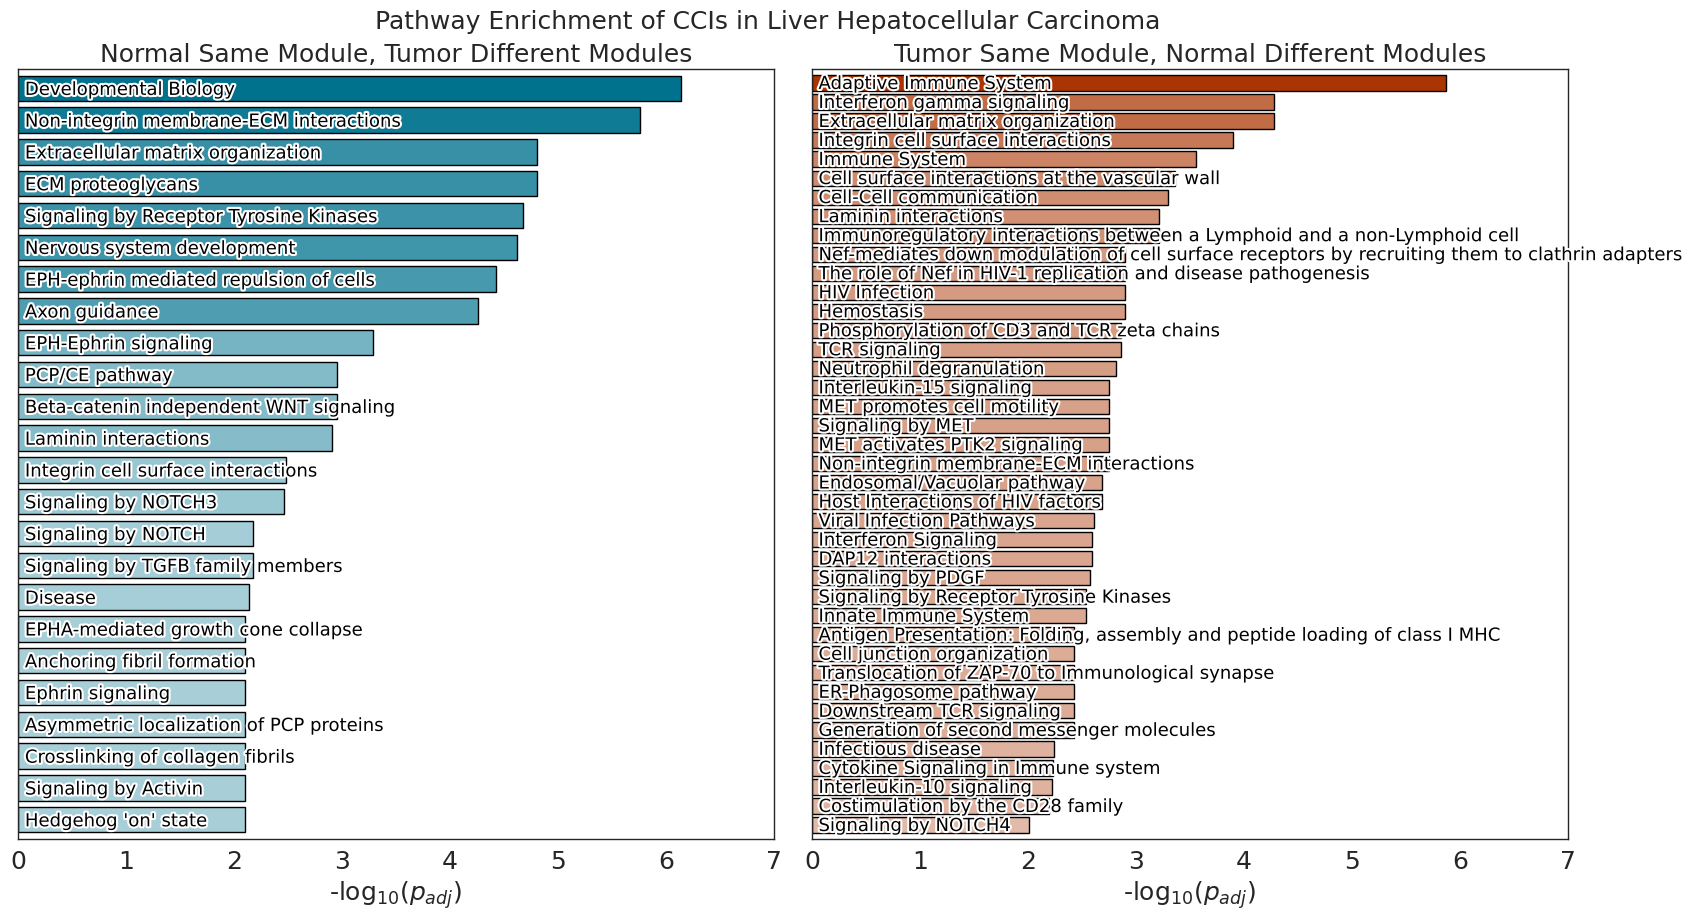

In [26]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.patheffects as path_effects

fs = 18 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={'wspace': 0.05, 'width_ratios': [1, 1]})

fig.suptitle('Pathway Enrichment of CCIs in Liver Hepatocellular Carcinoma', fontsize=fs, y=0.94)

x_offset = 0.01
y_offset = -0.05

# Compute -log10(pvalue) for the data
n_enr['-log10(pvalue)'] = -np.log10(n_enr["Adjusted P-value"])
t_enr['-log10(pvalue)'] = -np.log10(t_enr["Adjusted P-value"])

# Create colormap for first plot
cmap1 = mcolors.LinearSegmentedColormap.from_list("custom_gradient", ["white", ncolor])
norm1 = mcolors.Normalize(vmin=0, vmax=n_enr["-log10(pvalue)"].max())
colors1 = cmap1(norm1(n_enr["-log10(pvalue)"].values))

bars1 = ax1.barh(n_enr["Term"], n_enr["-log10(pvalue)"], color=colors1, edgecolor='k', lw=1)
ax1.set_title('Normal Same Module, Tumor Different Modules', fontsize=fs)
ax1.set_xlabel("-log$_{10}$($p_{adj}$)", fontsize=fs)
ax1.tick_params(labelsize=fs)
ax1.set_yticklabels([])  # Remove y-axis labels

# Add text labels inside bars with offset and outline
xlim1 = ax1.get_xlim()[1]
for bar, label in zip(bars1, n_enr["Term"]):
    text = ax1.text(x_offset * xlim1, bar.get_y() + bar.get_height()/2 + y_offset, label, 
                    va='center', ha='left', fontsize=13, color='black', 
                    path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    
ylim1, ylim2 = ax1.get_ylim()
ax1.set_ylim(ylim1 + 0.04 * ylim2, 0.96 * ylim2)

# Create colormap for second plot
cmap2 = mcolors.LinearSegmentedColormap.from_list("custom_gradient", ["white", tcolor])
norm2 = mcolors.Normalize(vmin=0, vmax=t_enr["-log10(pvalue)"].max())
colors2 = cmap2(norm2(t_enr["-log10(pvalue)"].values))

bars2 = ax2.barh(t_enr["Term"], t_enr["-log10(pvalue)"], color=colors2, edgecolor='k', lw=1)
ax2.set_title('Tumor Same Module, Normal Different Modules', fontsize=fs)
ax2.set_xlabel("-log$_{10}$($p_{adj}$)", fontsize=fs)
ax2.tick_params(labelsize=fs)
ax2.set_yticklabels([])  # Remove y-axis labels

# Add text labels inside bars with offset and outline
xlim2 = ax2.get_xlim()[1]
for bar, label in zip(bars2, t_enr["Term"]):
    text = ax2.text(x_offset * xlim2, bar.get_y() + bar.get_height()/2 + y_offset, label, 
                    va='center', ha='left', fontsize=13, color='black', 
                    path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])

ylim1, ylim2 = ax2.get_ylim()
ax2.set_ylim(ylim1 + 0.04 * ylim2, 0.96 * ylim2)

# Set the same xlim for both axes based on the max of -log10(pvalue)
xlim1 = round(0.5 + n_enr['-log10(pvalue)'].max())
xlim2 = round(0.5 + t_enr['-log10(pvalue)'].max())
ax1.set_xlim(0, max(xlim1, xlim2))
ax2.set_xlim(0, max(xlim1, xlim2))

# Uncomment to save the figure
# plt.savefig('/home/lnemati/pathway_crosstalk/results/flow/enrichment/liver_enrichment.png', dpi=300, bbox_inches='tight')
# plt.savefig('/home/lnemati/pathway_crosstalk/results/flow/enrichment/liver_enrichment.pdf', dpi=300, bbox_inches='tight')

plt.show()


In [27]:
# liver tumor
genes = pd.read_csv('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/liver/tumor/liver_hepatocellular_carcinoma/t_same_n_diff.csv')
genes = set(genes.interaction.apply(lambda x: re.split(r'[+_]', x)).sum())
print(len(genes))
print()
print()

for gene in genes:
    print(gene)
    
# https://string-db.org/cgi/network?taskId=bs3L2zgZ5OPz&sessionId=b5g0RKHpcGe5

140


CD86
PTGDR2
SULT1E1
CXCL10
SDC4
LAMC1
THBS3
ADRA2C
ANGPT2
COL7A1
GJA1
CCR2
IL7
ANGPT1
NECTIN3
CD47
PLXNA1
JAM3
CX3CR1
LAMB2
JAG1
NOTCH3
FLT4
ITGB2
PGF
SFRP4
WNT2B
THBS4
CCR1
KDR
COL3A1
HLA-DOB
PDGFA
CDH1
CCL8
TEK
NOTCH4
SV2A
CCL5
CYSLTR1
LAMB3
IL2RB
COL4A5
ANGPTL4
PLA2G7
IGF2R
PDGFRA
SGPP1
HLA-DPA1
HLA-DPB1
ITGB1
CD28
CXCL11
CCR5
PTPRC
NRP2
COL9A3
CD8A
PTGIS
PTGIR
GJA5
BCHE
CD22
CXCL9
SRD5A2
PPARD
CHRM3
VSIR
S1PR4
DBH
CCL4
AR
COL27A1
HLA-DMB
SPN
HLA-DRA
LCK
CCL3
ITGA5
SEMA5B
CD4
LTC4S
CD226
HLA-DQA2
TYROBP
NOTCH1
CD36
VEGFC
NAMPT
HLA-A
PLA2G2A
KLRK1
GGT5
SORT1
CX3CL1
IL2RG
SIRPB1
SULT1A1
CD44
HLA-F
SDC2
HPGD
ITGA6
PPARA
DLL1
ITGAL
CXCR3
CSF1
ACHE
PVR
LILRB1
PDGFRB
PDGFD
PTAFR
COL26A1
ITGA2
JAM2
LILRB2
PLAU
IL7R
PLAUR
ADGRG1
IL15RA
LAMA3
LAMA2
HLA-E
HLA-B
ICAM1
COL9A2
ITGAM
ITGAX
FN1
IGF2
SRD5A1
GRN
CSF1R
ITGA7
HLA-C
CD8B
IL15


In [28]:
# liver normal
genes = pd.read_csv('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/liver/tumor/liver_hepatocellular_carcinoma/n_same_t_diff.csv')
genes = set(genes.interaction.apply(lambda x: re.split(r'[+_]', x)).sum())
print(len(genes))
print()
print()

for gene in genes:
    print(gene)
    
# https://string-db.org/cgi/network?taskId=bgMAaM1yDTVP&sessionId=b5g0RKHpcGe5

360


COL6A3
TGFBR1
C5AR2
SELE
CD248
CYP3A4
PLXNA1
SELL
JAM3
ADRB2
NGF
LTB4R
PTGER2
NLGN2
ITGB2
PTPRD
COL4A2
SLC29A3
FDXR
TNN
EPHB4
PLG
NTRK2
DHRS11
C5
CYP27B1
SGPP1
GDF11
GLS
LAMB1
SLC29A2
EFNB1
SELP
EFNA4
GRIA3
PILRA
ADA
HGF
CBR1
CHRM5
TNC
FRZB
KITLG
CXCL8
DBH
NR1I2
PNP
FZD3
ADGRG6
IGF1
SCARA5
S1PR3
PDGFB
CCL3
KIT
P2RY1
C5AR1
CD226
AKR1C3
PLXNA4
EPOR
LRP1
EPHB1
SORT1
CD44
OXT
F2
LAMC3
ACKR2
CXCL1
CLSTN2
NCAM1
PTGDS
ADORA2A
PDGFRB
CXCR2
PTAFR
HBEGF
FGFR2
ADRA1A
EPHA2
APLP2
APP
WNT3
EGFR
SHH
VDR
ITGB5
WNT5A
PLXNA3
LAMC1
THBS3
TENM1
PPARG
ITGAE
PODXL
CD47
DHCR7
DAG1
MET
BOC
LAMB2
ACVR1C
TNFSF14
POMC
WNT5B
WNT2B
VEGFA
HFE
EPHA1
CDH1
ICAM2
RSPO3
CCL5
UNC5C
EPHB3
ANGPTL4
LRP5
ACKR3
BMP8B
S1PR1
PTCH2
VWF
DHCR24
GDF7
COL9A3
LTBR
EFNA3
ANGPTL2
EFNB2
CXCL9
SFRP5
FTL
ADRA2B
ACVR2A
FLRT1
C3
NECTIN1
PTPRF
NTN4
SLIT2
MC1R
AR
EPHA4
ERBB2
PLXNB2
S1PR2
TLR4
CXCR1
IL6R
RORC
GPER1
FGF2
PTGES2
FZD4
MDK
LRRC4B
ADRA1B
FGF7
CLEC4M
CXCL6
SEMA3B
ITGA6
CD34
EFNA2
SEMA5A
CEL
IGF1R
CD96
AKR1D1
SLC1A2
LRP6
NRXN2

In [56]:
#bkg = '_with_background'
bkg = '_without_background'

# Prostate
t_enr = pd.read_csv('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/prostate/tumor/prostate_adenocarcinoma/t_same_n_diff_enrichr'+bkg+'.csv')
t_enr = t_enr[t_enr['Adjusted P-value'] < 0.01]
#t_enr = t_enr.sort_values(by='Odds Ratio')
t_enr = t_enr.sort_values(by='P-value', ascending=False)
t_enr['Log Odds Ratio'] = np.log2(t_enr['Odds Ratio'])

n_enr = pd.read_csv('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/prostate/tumor/prostate_adenocarcinoma/n_same_t_diff_enrichr'+bkg+'.csv')
n_enr = n_enr[n_enr['Adjusted P-value'] < 0.01]
#n_enr = n_enr.sort_values(by='Odds Ratio')
n_enr = n_enr.sort_values(by='P-value', ascending=False)
n_enr['Log Odds Ratio'] = np.log2(n_enr['Odds Ratio'])


In [57]:
print(t_enr.shape)
print(n_enr.shape)

(203, 8)
(99, 8)


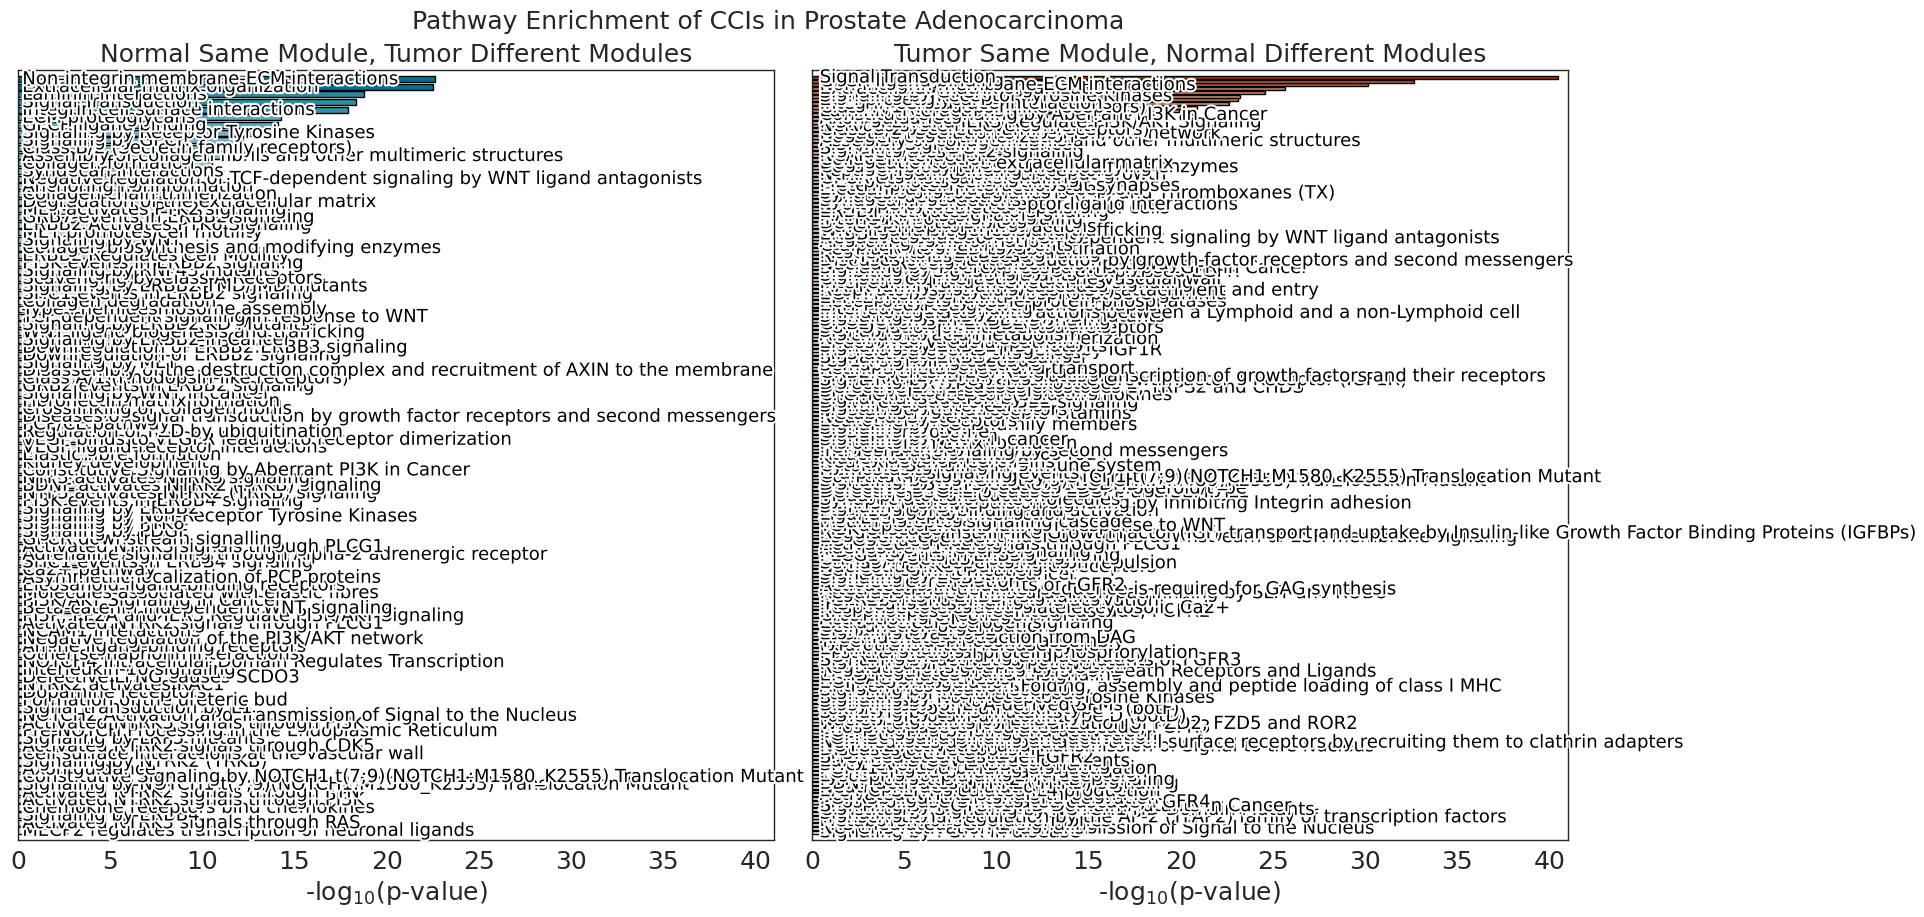

In [58]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.patheffects as path_effects

fs = 18 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={'wspace': 0.05, 'width_ratios': [1, 1]})

fig.suptitle('Pathway Enrichment of CCIs in Prostate Adenocarcinoma', fontsize=fs, y=0.94)

x_offset = 0.01
y_offset = -0.05

# Compute -log10(pvalue) for the data
n_enr['-log10(pvalue)'] = -np.log10(n_enr["P-value"])
t_enr['-log10(pvalue)'] = -np.log10(t_enr["P-value"])

# Create colormap for first plot
cmap1 = mcolors.LinearSegmentedColormap.from_list("custom_gradient", ["white", ncolor])
norm1 = mcolors.Normalize(vmin=0, vmax=n_enr["-log10(pvalue)"].max())
colors1 = cmap1(norm1(n_enr["-log10(pvalue)"].values))

bars1 = ax1.barh(n_enr["Term"], n_enr["-log10(pvalue)"], color=colors1, edgecolor='k', lw=1)
ax1.set_title('Normal Same Module, Tumor Different Modules', fontsize=fs)
ax1.set_xlabel("-log$_{10}$(p-value)", fontsize=fs)
ax1.tick_params(labelsize=fs)
ax1.set_yticklabels([])  # Remove y-axis labels

# Add text labels inside bars with offset and outline
xlim1 = ax1.get_xlim()[1]
for bar, label in zip(bars1, n_enr["Term"]):
    text = ax1.text(x_offset * xlim1, bar.get_y() + bar.get_height()/2 + y_offset, label, 
                    va='center', ha='left', fontsize=13, color='black', 
                    path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])

ylim1, ylim2 = ax1.get_ylim()
ax1.set_ylim(ylim1 + 0.04 * ylim2, 0.96 * ylim2)

# Create colormap for second plot
cmap2 = mcolors.LinearSegmentedColormap.from_list("custom_gradient", ["white", tcolor])
norm2 = mcolors.Normalize(vmin=0, vmax=t_enr["-log10(pvalue)"].max())
colors2 = cmap2(norm2(t_enr["-log10(pvalue)"].values))

bars2 = ax2.barh(t_enr["Term"], t_enr["-log10(pvalue)"], color=colors2, edgecolor='k', lw=1)
ax2.set_title('Tumor Same Module, Normal Different Modules', fontsize=fs)
ax2.set_xlabel("-log$_{10}$(p-value)", fontsize=fs)
ax2.tick_params(labelsize=fs)
ax2.set_yticklabels([])  # Remove y-axis labels

# Add text labels inside bars with offset and outline
xlim2 = ax2.get_xlim()[1]
for bar, label in zip(bars2, t_enr["Term"]):
    text = ax2.text(x_offset * xlim2, bar.get_y() + bar.get_height()/2 + y_offset, label, 
                    va='center', ha='left', fontsize=13, color='black', 
                    path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])

ylim1, ylim2 = ax2.get_ylim()
ax2.set_ylim(ylim1 + 0.04 * ylim2, 0.96 * ylim2)

# Set the same xlim for both axes based on the max of -log10(pvalue)
xlim1 = round(0.5 + n_enr['-log10(pvalue)'].max())
xlim2 = round(0.5 + t_enr['-log10(pvalue)'].max())
ax1.set_xlim(0, max(xlim1, xlim2))
ax2.set_xlim(0, max(xlim1, xlim2))

# Uncomment to save the figure
# plt.savefig('/home/lnemati/pathway_crosstalk/results/flow/enrichment/prostate_enrichment.png', dpi=300, bbox_inches='tight')
# plt.savefig('/home/lnemati/pathway_crosstalk/results/flow/enrichment/prostate_enrichment.pdf', dpi=300, bbox_inches='tight')

plt.show()


In [324]:
# prostate tumor
genes = pd.read_csv('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/prostate/tumor/prostate_adenocarcinoma/t_same_n_diff.csv')
genes = set(genes.interaction.apply(lambda x: re.split(r'[+_]', x)).sum())
print(len(genes))
print()
print()

for gene in genes:
    print(gene)

# https://string-db.org/cgi/network?taskId=b0KDywglKj5l&sessionId=b8gvcmqPNF76

472


LTB4R2
LRP5
PTGES2
C3
OSMR
FZD10
IGF1R
ADA
TNFRSF10C
ADGRL2
CD28
NPY1R
SLITRK5
GJC1
ANGPTL7
ITGA6
NECTIN2
SEMA5B
IGF2R
WNT5A
COL12A1
LILRB4
SRD5A1
DDC
LAMC3
EPHA2
BMPR1A
EPHA7
PODXL2
NOTCH2
CBR1
ROBO2
SFTPD
LAIR1
CD47
NAAA
CYP27B1
TGFA
GPR37
HSPG2
TNFRSF10A
CLSTN1
POSTN
FZD5
PTGER4
ALDH1A3
TAX1BP3
TNFRSF6B
FZD2
CCL3
ANXA1
HDC
GGT7
GDE1
ACVR1C
NLGN1
WNT9A
SLIT2
TNFRSF10D
PLXNA3
TLR4
COL2A1
SEMA5A
GFRA3
NTF4
EPHA5
HLA-A
S1PR3
PDGFD
NAPEPLD
COL9A1
PVR
GRIN2D
THY1
EPHB4
ENTPD1
HLA-DOA
NGFR
UBASH3B
STRA6
CXCR3
LAMB2
PPARA
ENPP1
LRRC4B
THBS3
FCGRT
PTGES3
ACVR2A
WNT3
WNT10B
PTCH1
LAMC1
NAMPT
LAMA3
ACVR2B
BTC
CD8A
FN1
DHCR24
EPHB3
CLSTN2
CXCL9
SGPP1
LAMA1
BMP2
GRIK1
COL26A1
ACVR1B
S1PR2
COL4A5
DAG1
ADA2
LRP1
SDC4
ADGRB1
NRG4
ADGRL3
THRB
CD8B
CEACAM6
ADGRL1
TNFRSF10B
SEMA3C
CDH1
LAMB3
SEMA4A
FGFR2
LGR6
NOTCH1
JAG2
SLC1A1
PDGFC
DAGLB
COL6A1
PSAP
COL4A2
GPR143
GAD1
VEGFA
LAMC2
SEMA4G
VLDLR
ACKR2
PTGDS
PTPRF
PTPRD
ESR1
CXCL11
THBS1
TENM3
DLL1
GRIK3
BMPR1B
HLA-B
CHRM3
TENM4
LTA4H
CYSLTR2
RORA

In [325]:
# prostate normal
genes = pd.read_csv('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/prostate/tumor/prostate_adenocarcinoma/n_same_t_diff.csv')
genes = set(genes.interaction.apply(lambda x: re.split(r'[+_]', x)).sum())
print(len(genes))
print()
print()

for gene in genes:
    print(gene)

# https://string-db.org/cgi/network?taskId=bhOqxiYqDywQ&sessionId=b8gvcmqPNF76

114


CCRL2
LRP5
WNT3A
COL21A1
FTH1
COL8A2
NRG2
EFNB1
GRM2
ADRA2B
NTRK2
COL4A2
GAD1
LAMC2
SFRP4
UCN
HAVCR2
ITGA8
NOTCH4
DBH
SELP
VEGFD
KDR
ITGA6
ANGPT2
LILRB2
CCL19
PTGDS
COL12A1
PTPRF
ADGRE5
CCR5
LGALS9
WIF1
ITGA9
NOTCH2
ITGB4
FZD4
THBS1
FZD5
DLL1
PTGER4
PTPRC
TNFRSF6B
DKK1
GPR17
SFRP2
FZD2
NTRK3
CD22
DRD1
PTGDR2
NTN4
PRSS2
CRHR1
LRRTM1
WNT5B
FLT4
ADRA2C
FGFR4
LAMA5
ITGB1
COL4A1
TGFBR3
WNT11
PRSS1
VTN
ERBB4
COL24A1
SFRP5
FZD9
THY1
EPHB4
ITGA7
ITGA1
PTGS2
NRXN1
LPAR1
CD34
ADGRB3
TEK
CD69
ENPP1
NTF3
FZD1
SCARA5
F2RL3
KLRB1
WNT3
FTL
LAMA3
FN1
TNC
SORT1
TNFSF14
LAMA4
ITGA5
ERBB2
FZD3
FRZB
C1QL1
COL4A4
CD1D
NRG1
COL4A3
SFRP1
BDNF
SDC4
WNT16
CCL5
JAG1
DRD2
LRRC4C
ERBB3
